# Road Fatal Crashes Australia


The focus of my capstone is *__Fatal Road Crashes in Australia__*. This is a problem for both developing and developed countries like *__Australia__*. The World Health Organization consideres this as a health community issue and recommends making it a political priority, as such I predict this will be of great interest to both *__goverments and industries working with government__*.

The focus of this study is *twofold*, firstly to address the *__loss of life__* in traffic accidents. In a single blink of eye life can change for an individual, a family and even whole communities with the loss of individual lives. In addition to this very serious issue of the loss of life accidents can also affect the *__functionality of whole cities__*. Road accidents at some point can cause traffic congestion, problems with supply delivery and the operation of any city or area.

I address the specific question: *__“Can Australia continue to reduce further the number of road fatalities?”__*

I *__will predict__* if Australia can reduce the *__number of road fatalities__* and discuss the implications of my findings. With this project I hope to encourage and *__motivate people, industries and government towards safer Australia roads__*.

Some road safety initiatives has been implemented in Australia to reduce the number of road fatalities

- Motor Act 1932 required all vehicles to adhere to safety standards for maintenance of tyres, rear-view mirrors 
     and vehicle horns.
- Legislation passed in Victoria requiring the wearing of motorcycle helmets.
- Australian Design Rules for mandatory fitting of seat belts in new passenger vehicles.
- Victoria became first in the world to introduce compulsory wearing of seat belts. By 1973, legislation was
     passed throughout Australia for compulsory wearing of fitted seat belts in motor vehicles.
- Victoria introduced random breath testing and legislation was passed in Victoria requiring child restraints
     in motor vehicles.
- Intensification of random breath testing in New South Wales.
- Introduction of intensive road safety advertising
- National 0.05 blood alcohol concentration limit
- National licensing of heavy truck and bus drivers
- Zero blood alcohol limits for young drivers
- Graduated licensing system for young drivers
- Introduction of speed camera.
- Introduction of 50 km/h speed limits in urban residential areas and more.



## Acquire Data
---
### This dataset is come from The Bureau of Infrastructure, Transport and Regional Economics (BITRE). Thier website can be access with this URL link https://bitre.gov.au/.¶
---

##### Import needed Libraries

This are libraries that we need to import, the source code will use them on their respective processes. I put them in once cell so that everything will be import in one execution and to make our code clean and organize. Everytime we need to import libraries we can alway put into this cell.

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import sqlite3
from pandas.io import sql
import calendar
import datetime

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.decomposition import PCA

import warnings
import itertools
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_style('darkgrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#####  Functions definitions

This are custom function that has their uses. 
- First `load_csv_to_db` is use to load the data from CSV into database, in this case we use SQLITE3. 
- Second `get_data_from_db` is use to fetch data from database into dataframe. 
- Third `load_df_to_db` is use to load the data from dataframe into database. 
- Last `correlation_heat_map` is use to plot the correllation of each features from dataframe

In [2]:
def load_csv_to_db(file_path,dbfile_path,tablename):
    csv_file = file_path
    df = pd.read_csv(csv_file)    
    for column in df.columns:
        df.rename(columns = {column: column.replace(' ','_')},inplace = True)
        df.rename(columns = {column: column.replace('/','_')},inplace = True)
    db_connection = sqlite3.connect(dbfile_path)
    df.to_sql(name=tablename,con=db_connection,if_exists='replace',index=True)    
    print("The file %s is successfully loaded in database file %s in table %s" %(file_path,dbfile_path,tablename))
    return df
    db_connection.close()
    
def get_data_from_db(query,db_file):
    db_connection = sqlite3.connect(db_file)
    data = sql.read_sql(query, con = db_connection)
    return data
    db_connection.close()
    
def load_df_to_db(df,dbfile_path,tablename):
    db_connection = sqlite3.connect(dbfile_path)
    df.to_sql(name=tablename,con=db_connection,if_exists='replace',index=True)
    print("The dataframe %s is successfully loaded in database file %s in table %s" %(df,dbfile_path,tablename))
    db_connection.close()


def correlation_heat_map(df):
    corrs = df.corr()
    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(25,25))
    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)
    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

##### Let's look the dataset. This dataset is come from The Bureau of Infrastructure, Transport and Regional Economics (BITRE). Thier website can be access with this URL link https://bitre.gov.au/. 

I got two csv file from their web site and here are the details:

1. Fatal_Crashes_Feb2017.csv - This file contains the details of fatal crashes like 
   - Crash_ID = National crash-identifying number Integer 13-digit, unique to each fatal crash
   - State = Australian jurisdiction Text Abbreviation for each state/territory
   - Year = Year of crash Integer
   - Month = Month of crash 
   - Day = Day of month of crash Integer 1-31
   - Hour = Hour of crash Integer 0 to 23
   - Minute = Minute Integer 0 to 59
   - Crash_Type = Code summarising type of crash: three values relating to the number of vehicles involved, and
      whether a pedestrian was killed (Single, Multiple Pedestria)
   - Number of Fatalities = Number of killed persons (fatalities) in the crash
   - Bus_Involvement = Indicates involvement of a bus in the crash (Yes,No)
   - Heavy_rigid_truck_Involvement = Indicates involvement of a heavy rigid truck in the crash(Yes,No)
   - Artic_truck_Involvement - Indicates involvement of an articulated truck in the crash (Yes,No)
   - Speed Limit = Posted speed limit at location of crash.
   
2. Fatalities_Feb2017.csv - it has same column with file on number 1, the difference between them is this
   file does not Number of Fatalities but since this is detailed information list of person died in accident and
   also the fatal crashes we can assign value of 1 to column Number_of_Fatalities on each row. So if we get the sum
   of each 1 by grouping the Crash_ID the sum of it is equal to the Number_of_fatalities column in file on number 1
   - Road_User = Road user type of died person (Driver, Passenger, Pedestrian, Motorcycle rider, Motorcycle pillion 
      passenger, Bicyclist (includes pillion passengers))
   - Gender = Sex of died person (Male and Female)
   - Age = Age of died (years)

---

### The data from both files will be loaded in database for safe keeping and data retrieval purpose once we need them.

In [3]:
csvfile_path = './datasets/Fatal_Crashes_Feb2017.csv'
db_file = './db/australia_roads.db.sqlite'  
table_name = 'fatal_crashes'
fatal_crashes = load_csv_to_db(csvfile_path,db_file,table_name)

The file ./datasets/Fatal_Crashes_Feb2017.csv is successfully loaded in database file ./db/australia_roads.db.sqlite in table fatal_crashes


In [4]:
csvfile_path = './datasets/Fatalities_Feb2017.csv'
table_name = 'fatalities'
fatalities = load_csv_to_db(csvfile_path,db_file,table_name)

The file ./datasets/Fatalities_Feb2017.csv is successfully loaded in database file ./db/australia_roads.db.sqlite in table fatalities


### Data Cleaning
Since the data is safe keep in database, we can fetch also the data from database and we can start the data cleaning. Explain how we will clean that data what are the things we need to consider in cleaning out data.

Note: Missing values for numeric fields are coded with ‘-9’; for text fields the value is 'Unknown'. 

- Hour and Minute = a value of -9 will not included on rows to be return on our SQL query. We will not use them
- Speed Limit of -9, 900, 888 and 777 are not realistic we will not include them.
- Gender with Unknown value should not be included in this case we will 
- Age of -9 should not be included.
- Year = 2017 will not be included because its only represent partial data of 2017.

---

#### The data set will be loaded on `fatal` dataframe.

In [5]:
query ='''
SELECT f.CrashID
     , f.State 
     , f.Year
     , f.Month
     , f.Day    
     , f.Hour
     , f.Minute
     , f.Crash_Type
     , 1 as Number_of_Fatalities
     , f.Bus_Involvement
     , f.Articulated_Truck_Involvement
     , f.Speed_Limit
     , f.Road_User
     , f.Gender
     , f.Age
  FROM fatalities f
 WHERE (Hour != -9 OR Minute != -9)  
   AND (Speed_Limit not in (-9,900,888,777))
   AND Gender != 'Unknown'   
   AND Age != -9   
   AND Year != 2017
'''
fatal = get_data_from_db(query,db_file)

### Insert the clean rows of dataframe into database for safe keeping and data retrieval.

This is the clean data that I will used for my analysis and also for modeling. Before we will use the clean data I will do some check like columns for the data, data type, shape and also check if the are NULL values. I want also to check if there are correlated varaiables in my dataset.

In [6]:
load_df_to_db(fatal,db_file,'fatal_clean')
fatal.head()

The dataframe              CrashID State  Year     Month  Day  Hour  Minute  \
0      4201601010001    SA  2016   January    1     1       0   
1      2201601010001   VIC  2016   January    1    20      30   
2      1201601020001   NSW  2016   January    2     0      30   
3      5201601020001    WA  2016   January    2    17      20   
4      6201601020001   TAS  2016   January    2    19      58   
5      6201601020001   TAS  2016   January    2    19      58   
6      6201601030002   TAS  2016   January    3    11      55   
7      3201601030001   QLD  2016   January    3    14       0   
8      2201601040002   VIC  2016   January    4     2       0   
9      5201601040002    WA  2016   January    4    15      47   
10     1201601040002   NSW  2016   January    4    20      25   
11     1201601040003   NSW  2016   January    4    21      45   
12     1201601050004   NSW  2016   January    5    10      30   
13     1201601070005   NSW  2016   January    7    11      45   
14     1201

CrashID State  Year    Month  Day  Hour  Minute        Crash_Type  \
0  4201601010001    SA  2016  January    1     1       0    Single vehicle   
1  2201601010001   VIC  2016  January    1    20      30    Single vehicle   
2  1201601020001   NSW  2016  January    2     0      30    Single vehicle   
3  5201601020001    WA  2016  January    2    17      20  Multiple vehicle   
4  6201601020001   TAS  2016  January    2    19      58  Multiple vehicle   

   Number_of_Fatalities Bus_Involvement Articulated_Truck_Involvement  \
0                     1              No                            No   
1                     1              No                            No   
2                     1              No                            No   
3                     1              No                           Yes   
4                     1              No                            No   

   Speed_Limit          Road_User Gender  Age  
0          110             Driver   Male   40  
1           80  Motor cycle rider   Male   25  
2          100          Passenger   Male   18  
3          110             Driver   Male   53  
4           80  Motor cycle rider   Male   17

#### Check the counts of columns and rows of the dataset

In [7]:
fatal.shape

(45928, 15)

#### Check the data types

In [8]:
fatal.dtypes

CrashID                           int64
State                            object
Year                              int64
Month                            object
Day                               int64
Hour                              int64
Minute                            int64
Crash_Type                       object
Number_of_Fatalities              int64
Bus_Involvement                  object
Articulated_Truck_Involvement    object
Speed_Limit                       int64
Road_User                        object
Gender                           object
Age                               int64
dtype: object

#### Describe the dataset

In [9]:
fatal.describe()

CrashID          Year           Day          Hour        Minute  \
count  4.592800e+04  45928.000000  45928.000000  45928.000000  45928.000000   
mean   2.834703e+12   2000.944740     15.753222     12.711614     20.533509   
std    1.592577e+12      8.053017      8.717612      6.445909     18.790296   
min    1.198901e+12   1989.000000      1.000000      0.000000      0.000000   
25%    1.200807e+12   1994.000000      8.000000      8.000000      0.000000   
50%    2.200910e+12   2000.000000     16.000000     14.000000     19.000000   
75%    4.199003e+12   2008.000000     23.000000     18.000000     35.000000   
max    8.201611e+12   2016.000000     31.000000     23.000000     59.000000   

       Number_of_Fatalities   Speed_Limit           Age  
count               45928.0  45928.000000  45928.000000  
mean                    1.0     83.096325     39.263848  
std                     0.0     20.422179     21.652386  
min                     1.0      8.000000      0.000000  
25%                     1.0     60.000000     22.000000  
50%                     1.0     80.000000     34.000000  
75%                     1.0    100.000000     55.000000  
max                     1.0    130.000000    100.000000

#### Check additional information

In [10]:
fatal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45928 entries, 0 to 45927
Data columns (total 15 columns):
CrashID                          45928 non-null int64
State                            45928 non-null object
Year                             45928 non-null int64
Month                            45928 non-null object
Day                              45928 non-null int64
Hour                             45928 non-null int64
Minute                           45928 non-null int64
Crash_Type                       45928 non-null object
Number_of_Fatalities             45928 non-null int64
Bus_Involvement                  45928 non-null object
Articulated_Truck_Involvement    45928 non-null object
Speed_Limit                      45928 non-null int64
Road_User                        45928 non-null object
Gender                           45928 non-null object
Age                              45928 non-null int64
dtypes: int64(8), object(7)
memory usage: 5.3+ MB


### Check if we have NULL values on each column. We don't have NULL values in dataframe.

In [11]:
fatal.isnull().sum()

CrashID                          0
State                            0
Year                             0
Month                            0
Day                              0
Hour                             0
Minute                           0
Crash_Type                       0
Number_of_Fatalities             0
Bus_Involvement                  0
Articulated_Truck_Involvement    0
Speed_Limit                      0
Road_User                        0
Gender                           0
Age                              0
dtype: int64

### Check for the correllated features
It does not show good correllation but it does not matter we can continue to check further on my data.

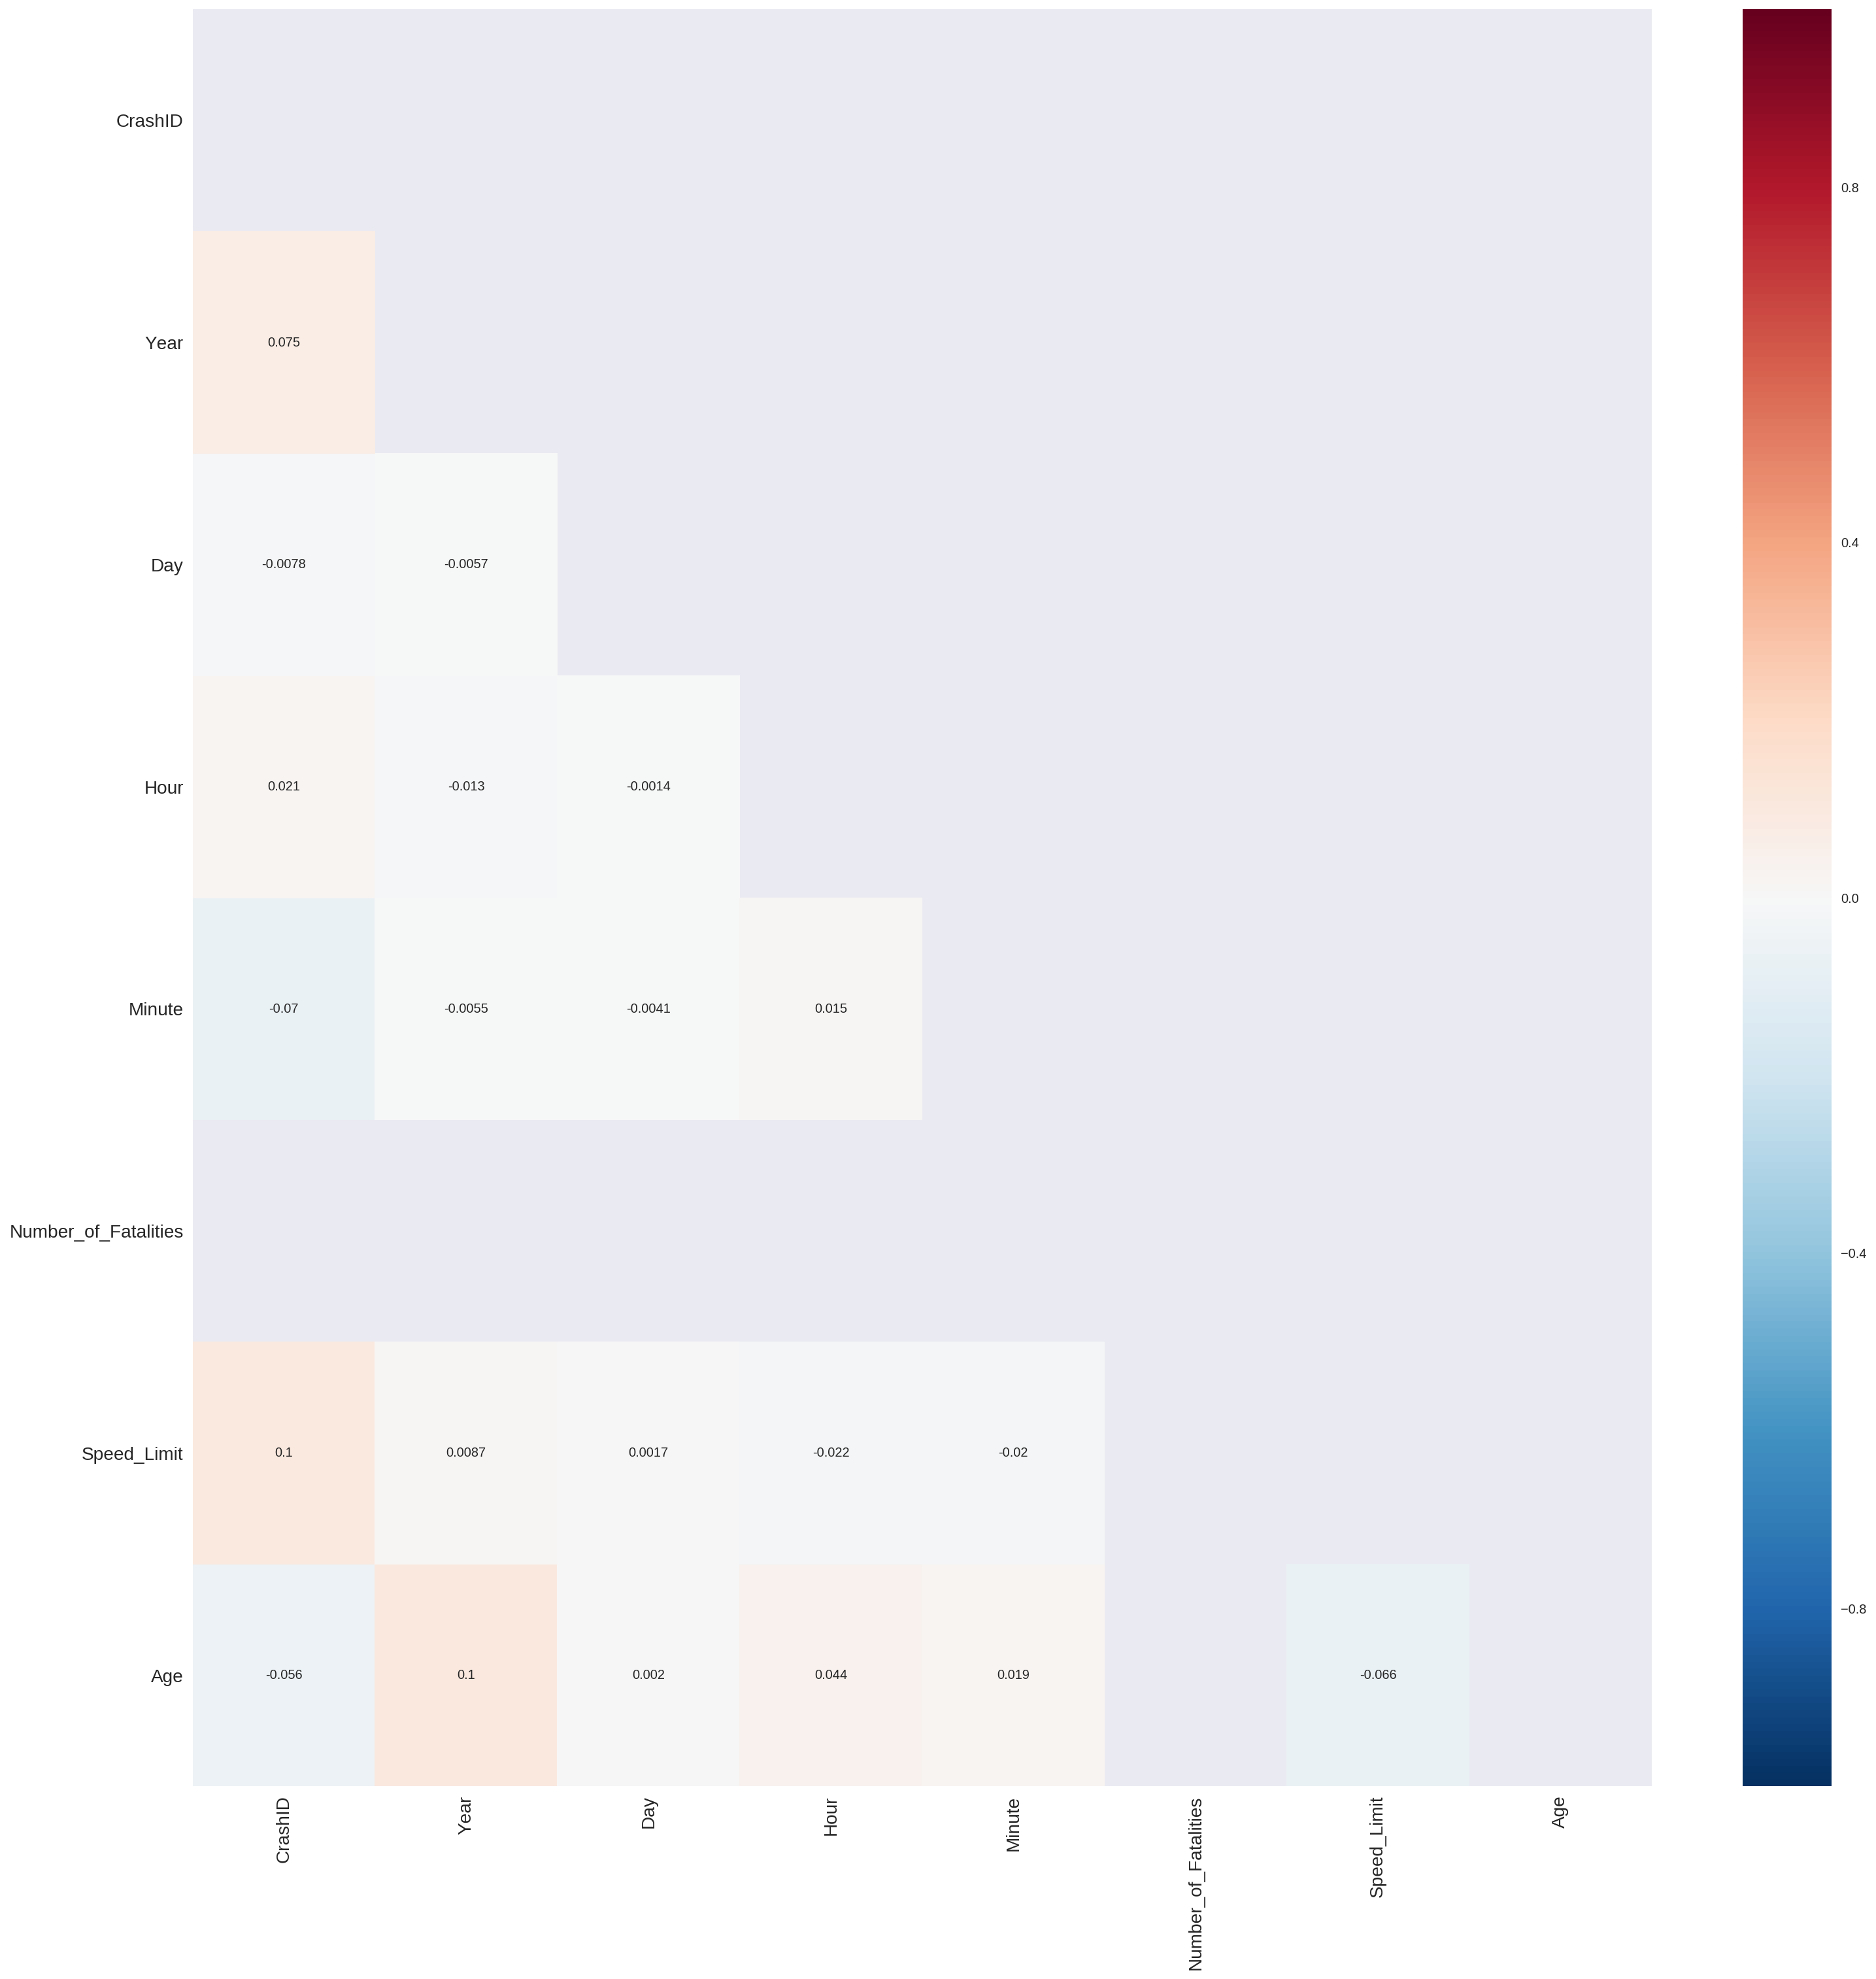

In [12]:
correlation_heat_map(fatal)

#### Since we have categorical variables that we can use in our model we can create dummy variable from them and merge in out `fatal_heat_map` dataframe and drop column we don't need. We will try if dummy variables give us better correlation or can provide us a better predictors.
Categorical
- State
- Month
- Crash_Type
- Bus_Involvement
- Articulated_Truck_Involvement
- Road_User
- Gender

In [13]:
Year_dummies = pd.get_dummies(fatal.Year, prefix='Year')
State_dummies = pd.get_dummies(fatal.State, prefix='State')
Month_dummies = pd.get_dummies(fatal.Month, prefix='Month')
Crash_Type_dummies = pd.get_dummies(fatal.Crash_Type, prefix='Crash_Type')
Bus_Involvement_dummies = pd.get_dummies(fatal.Bus_Involvement, prefix='Bus_Involvement')
Road_User_dummies = pd.get_dummies(fatal.Road_User, prefix='Road_User')
Gender_dummies = pd.get_dummies(fatal.Gender, prefix='Gender')
Articulated_Truck_Involvement_dummies = pd.get_dummies(fatal.Articulated_Truck_Involvement,
                                                       prefix='Articulated_Truck_Involvement')

#### Combine all the feature into `fatal_heat_map` dataframe and including dummies created.

In [14]:
fatal_heat_map = pd.concat([fatal,Year_dummies,State_dummies,Month_dummies,Crash_Type_dummies,
                            Bus_Involvement_dummies,Articulated_Truck_Involvement_dummies,
                            Road_User_dummies,Gender_dummies],axis = 'columns')

#### Rename column by replacing the space on each column name from dataframe with underscore. We need to do it because we don't want to encounter error when we try to use the column name in python command expression.

In [15]:
fatal_heat_map.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

#### Check the name of columns and check if there are columns with white space.

In [16]:
fatal_heat_map.columns

Index(['CrashID', 'State', 'Year', 'Month', 'Day', 'Hour', 'Minute',
       'Crash_Type', 'Number_of_Fatalities', 'Bus_Involvement',
       'Articulated_Truck_Involvement', 'Speed_Limit', 'Road_User', 'Gender',
       'Age', 'Year_1989', 'Year_1990', 'Year_1991', 'Year_1992', 'Year_1993',
       'Year_1994', 'Year_1995', 'Year_1996', 'Year_1997', 'Year_1998',
       'Year_1999', 'Year_2000', 'Year_2001', 'Year_2002', 'Year_2003',
       'Year_2004', 'Year_2005', 'Year_2006', 'Year_2007', 'Year_2008',
       'Year_2009', 'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013',
       'Year_2014', 'Year_2015', 'Year_2016', 'State_ACT', 'State_NSW',
       'State_NT', 'State_QLD', 'State_SA', 'State_TAS', 'State_VIC',
       'State_WA', 'Month_April', 'Month_August', 'Month_December',
       'Month_February', 'Month_January', 'Month_July', 'Month_June',
       'Month_March', 'Month_May', 'Month_November', 'Month_October',
       'Month_September', 'Crash_Type_Multiple_vehicle',
       'Crash_T

#### Drop the original column of dummies we created and also since we did not use the function drop_first of pandas.get_dummies we also need to manually drop one dummy variables on each group of dummies we created earlier.
- State_ACT - because of its data start only in year 2008
- Year_1989
- Month_January
- Crash_Type_Single_vehicle
- Bus_Involvement_Yes
- Road_User_Other/unknown
- Gender_Female

In [17]:
fatal_heat_map.drop(['CrashID','Year','State','Month','Crash_Type','Bus_Involvement','Road_User','Gender',
                     'Articulated_Truck_Involvement',
                     'State_ACT','Year_1989','Month_January','Crash_Type_Single_vehicle',
                     'Bus_Involvement_Yes','Road_User_Other/unknown','Gender_Female'], axis='columns',inplace=True)

Check the column and rows

In [18]:
fatal_heat_map.head()

Day  Hour  Minute  Number_of_Fatalities  Speed_Limit  Age  Year_1990  \
0    1     1       0                     1          110   40          0   
1    1    20      30                     1           80   25          0   
2    2     0      30                     1          100   18          0   
3    2    17      20                     1          110   53          0   
4    2    19      58                     1           80   17          0   

   Year_1991  Year_1992  Year_1993     ...       Bus_Involvement_No  \
0          0          0          0     ...                        1   
1          0          0          0     ...                        1   
2          0          0          0     ...                        1   
3          0          0          0     ...                        1   
4          0          0          0     ...                        1   

   Articulated_Truck_Involvement_No  Articulated_Truck_Involvement_Yes  \
0                                 1                                  0   
1                                 1                                  0   
2                                 1                                  0   
3                                 0                                  1   
4                                 1                                  0   

   Road_User_Bicyclist  Road_User_Driver  \
0                    0                 1   
1                    0                 0   
2                    0                 0   
3                    0                 1   
4                    0                 0   

   Road_User_Motor_cycle_pillion_passenger  Road_User_Motor_cycle_rider  \
0                                        0                            0   
1                                        0                            1   
2                                        0                            0   
3                                        0                            0   
4                                        0                            1   

   Road_User_Passenger  Road_User_Pedestrian  Gender_Male  
0                    0                     0            1  
1                    0                     0            1  
2                    1                     0            1  
3                    0                     0            1  
4                    0                     0            1  

[5 rows x 63 columns]

#### Check for correllation heatmap on `fatal_heat_map` just to see if there is something comes out to be correllated to each other. 
The heatmap doesn't gave us any good results, but we need to move forward and continue checking how we can do the prediction on number of road fatalities.

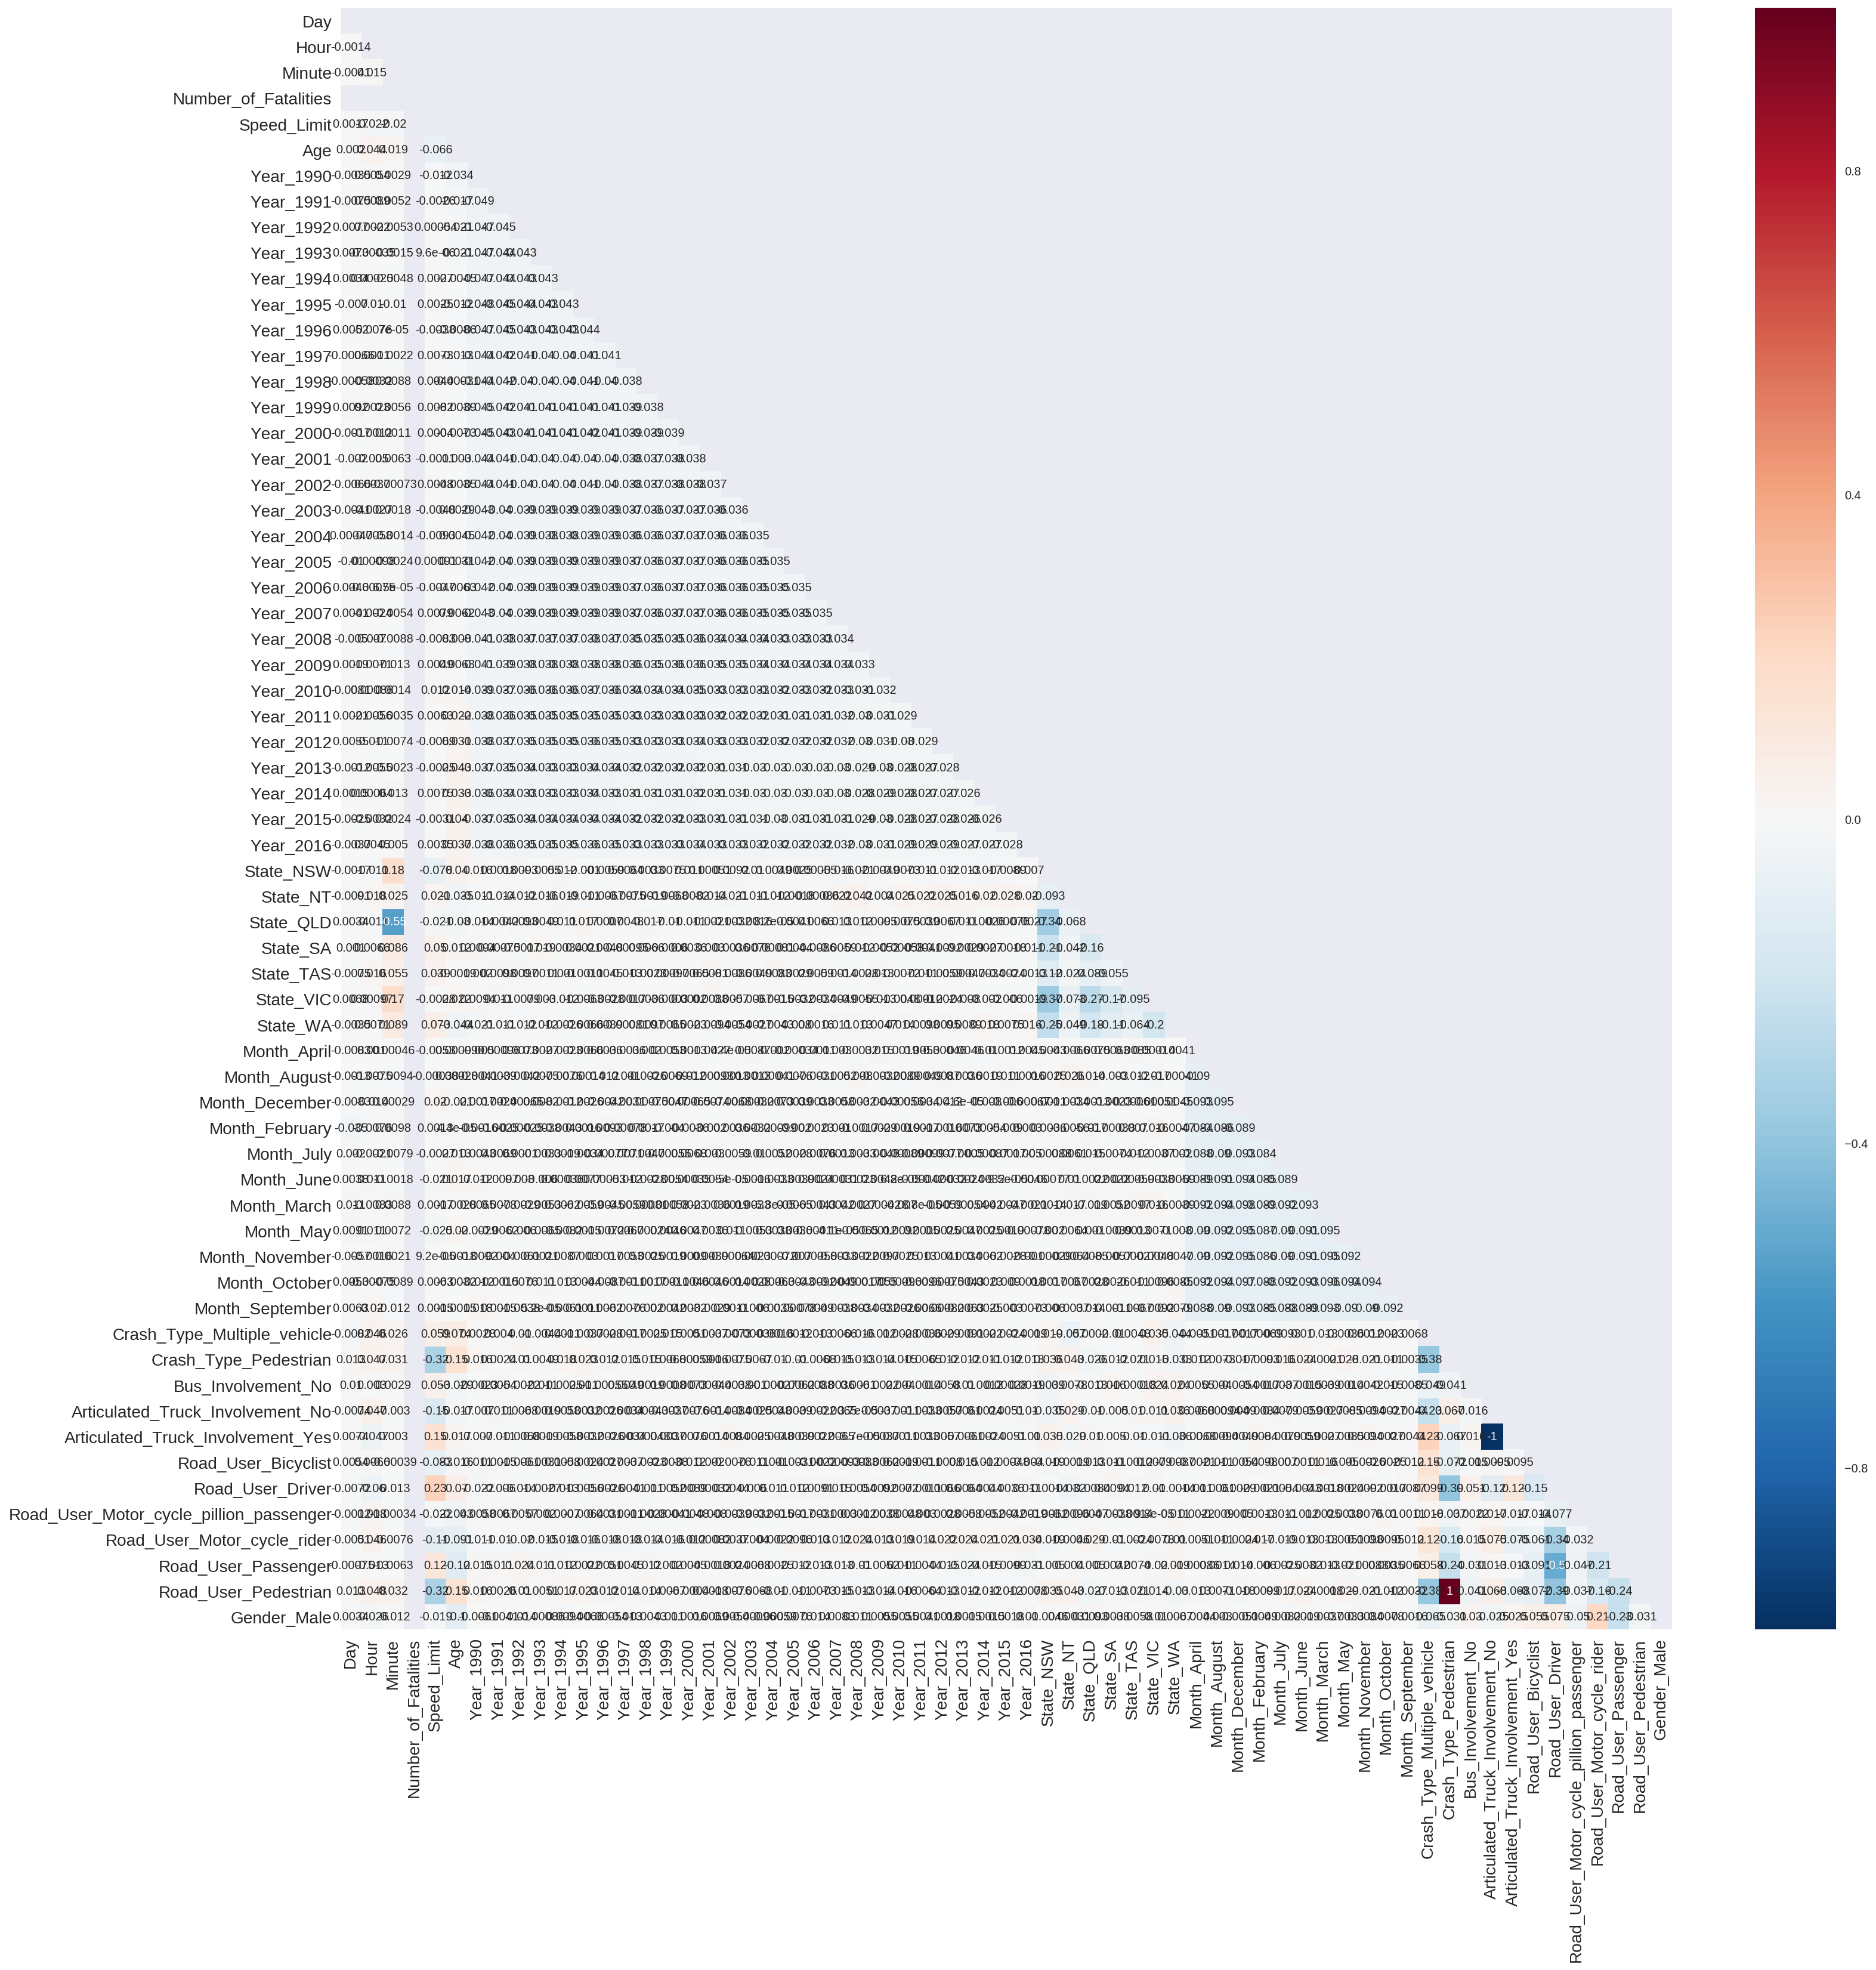

In [19]:
correlation_heat_map(fatal_heat_map)

### Identification of Outliers
#### Check if there is outliers from features that at not dummies. Assume that dummy variables does not have outliers.
 - There is no outliers

/home/andycenson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


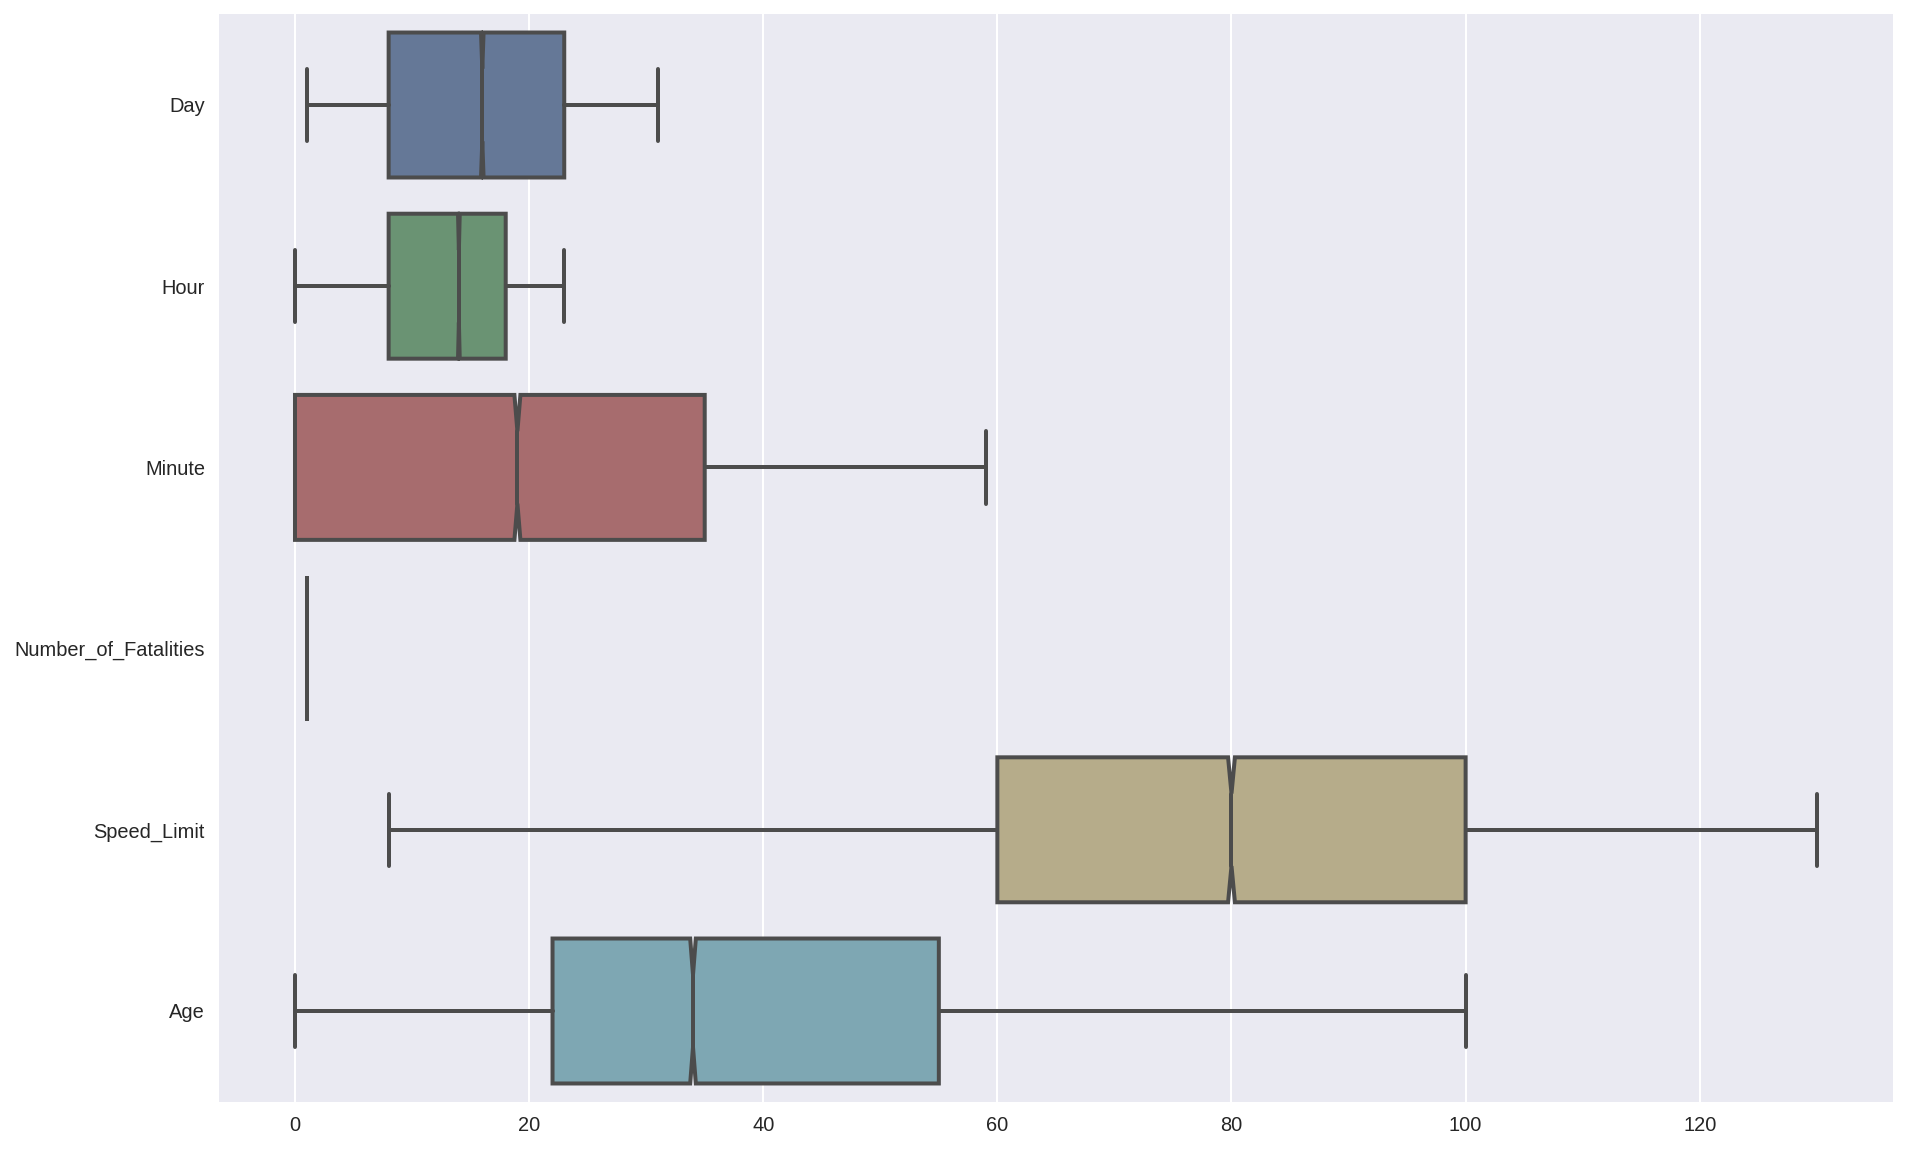

In [21]:
fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
sns.boxplot(fatal_heat_map.iloc[:, 0:6] , orient = 'h', fliersize = 4, linewidth = 2, notch = True, 
            saturation = 0.5, ax=ax)
plt.show()

#### Verify the minimum values for Minute column. I want to make sure that there is no negative value on it.

In [22]:
fatal_heat_map.Minute.values.min()

0

At this point the value of Number_of_Fatalities still equal to 1 because we did not group the records and it's on detailed structure of the dataset. When we work on EDA and modelling we can do group so that we can do SUM function to get the total number of fatalities base on group of features we are going to select.

## Visualizations & statistical analysis
#### EDA

#### NSW has the most number of fatalities and ACT has least number. One of the reason why NSW has most number of fatalities because it has also has higher population.

I group my data by `State` and get the SUM of `Number_of_Fatalities` and plot, this shows that NSW has most number of person died  in road fatal crashes.

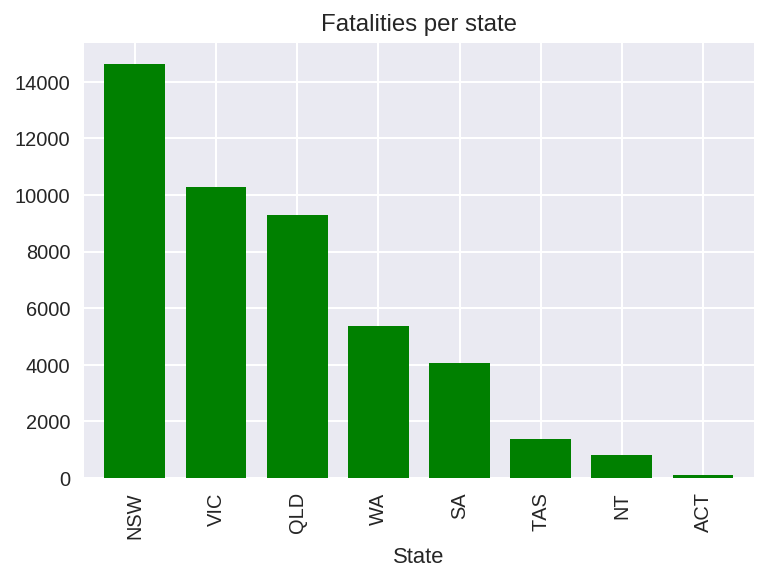

In [23]:
fatal_death_year = fatal[['State','Number_of_Fatalities']]
fatal_death_year = fatal_death_year.groupby('State')['Number_of_Fatalities'].sum().sort_values(ascending=False)
fatal_death_year.head(10).plot(kind='bar', color='green', width=0.75, title='Fatalities per state')
plt.show()

#### This is the population of each state in Australia if we will compare it to number of road fatalities we can say that they are correllated to most of the state.

I'm just curious to know why NSW has more number of person involved in accident and also more person died in fatal crashes, I think because NSW has more population and it might be a factor. I tried to get some data from internet to check the current population of each State and sort from highest to lowest. Look what I found, NSW has more population with other state. I also notice that the order of state with most number of fatalities has same order also in population at some state.

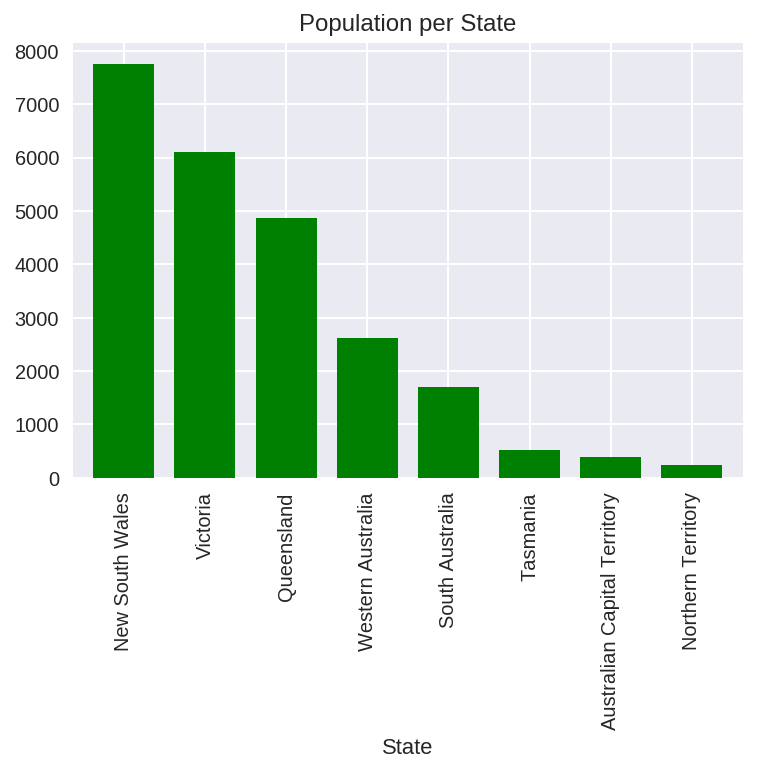

In [24]:
au_pop = pd.read_csv('./datasets/AU_Population.csv')
au_pop_pl = au_pop[['State','Population']]
au_pop_pl
au_pop_pl = au_pop_pl.groupby('State')['Population'].sum().sort_values(ascending=False)
au_pop_pl.head(10).plot(kind='bar', color='green', width=0.75, title='Population per State')
plt.show()

#### The number of fatalities descrease over the years in Australia and  I tried to play my SQL query statement and come up with query below which I group the rows by Year and get the SUM of Number_of_Fatalities and when i tried to plot it using lmplot it show the linearity of them. This give me idea that I can do Linear Regression with it.

#### Query the sum of `Number_of_Fatalities` and also `Year` column data from `fatal_clean` table, group by Year and use that to plot the linearity.

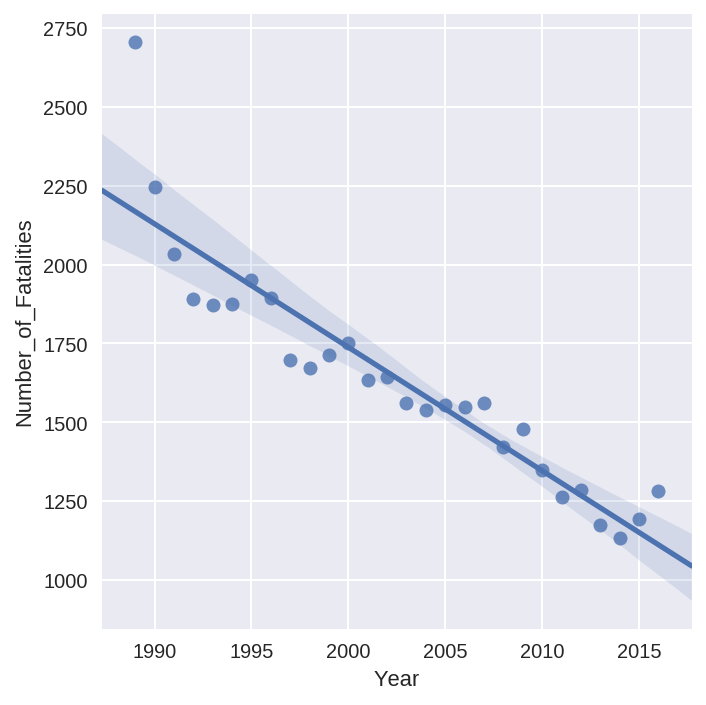

In [25]:
query ='''
SELECT Year, sum(Number_of_Fatalities) as Number_of_Fatalities
  FROM fatal_clean
 GROUP BY Year
'''
fatal_year = get_data_from_db(query,db_file)

plt.figure(figsize=(15,10))
sns.lmplot(x="Year", y="Number_of_Fatalities", data=fatal_year)
plt.show()

#### We can also visualize the individual performance of each state if they can control and reduce the number of fatalities in their respective jurisdiction. Just want to make clear what I want to predict is if Australia as a whole can be able to reduce the number of road fatalities. This plot shows only individual performance of each State.

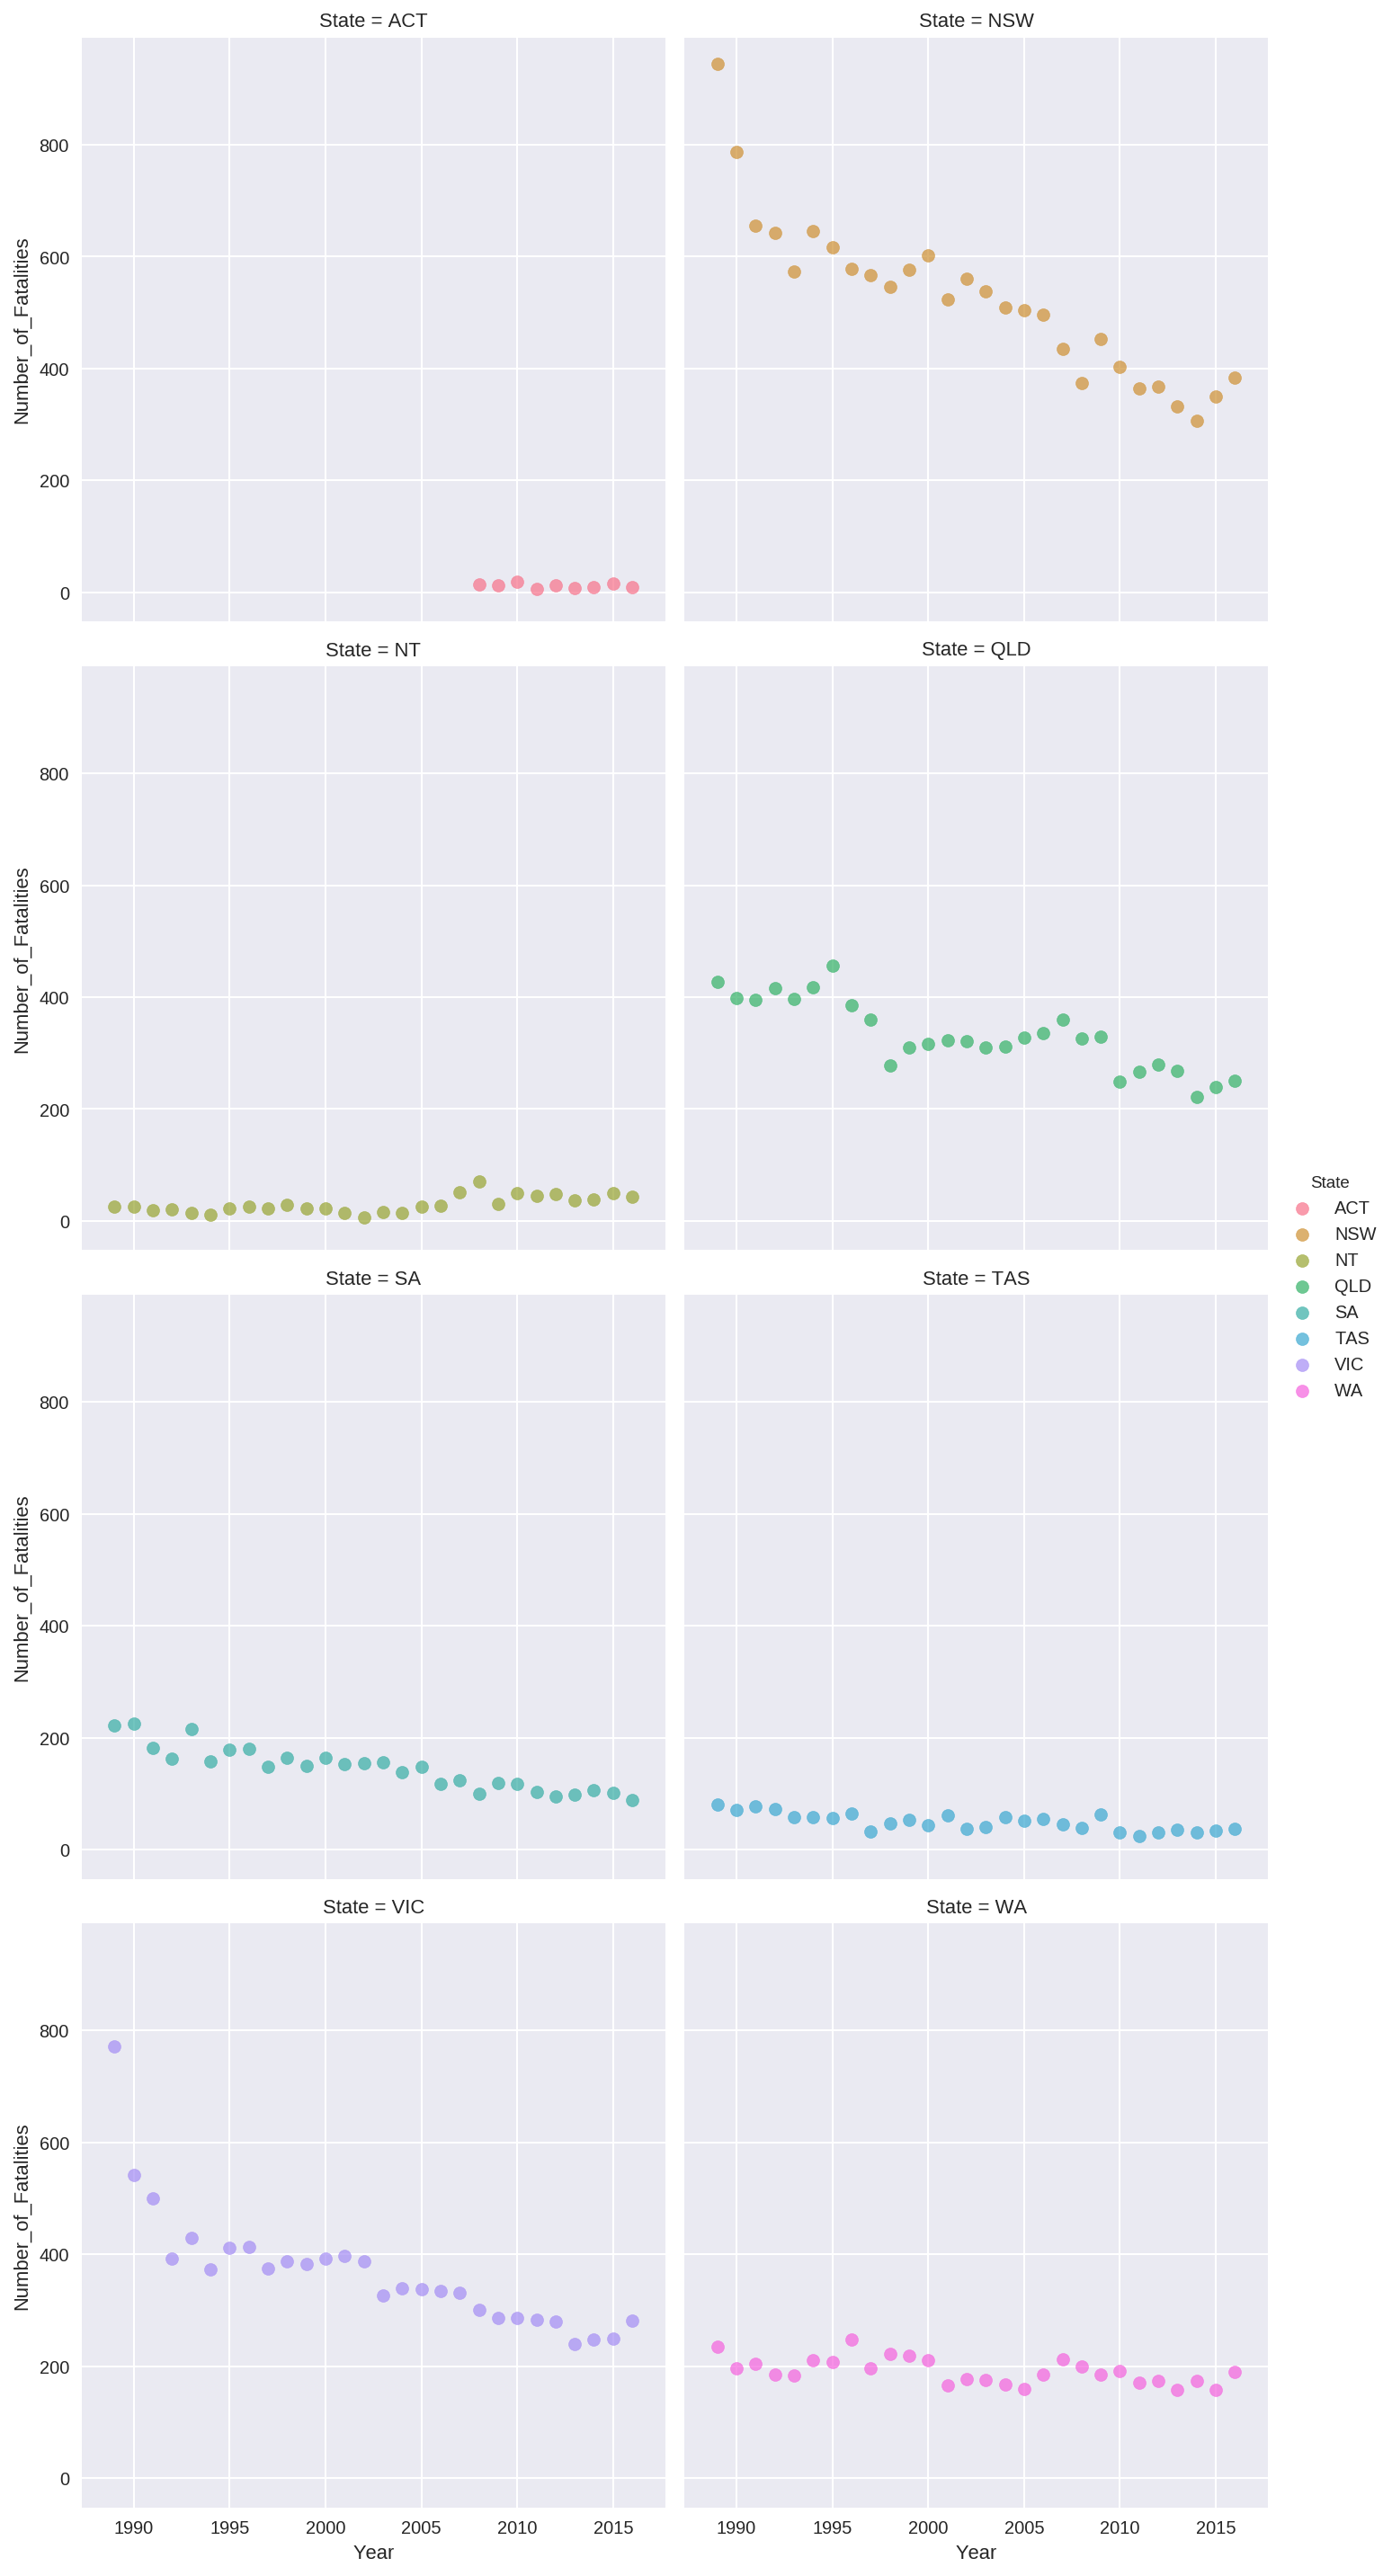

In [26]:
query ='''
SELECT State,Year, sum(Number_of_Fatalities) as Number_of_Fatalities
  FROM fatal_clean
 GROUP BY State,Year
'''
fatal_death_year = get_data_from_db(query,db_file)
g = sns.FacetGrid(fatal_death_year, col_wrap=2, col="State", hue="State",size=5,aspect=1)
g.map(plt.scatter, "Year", "Number_of_Fatalities", alpha=.7)
g.add_legend();

#### This shows that only few accidents where Bus is involve and also only few people died per year. I could say that it's safer to ride a bus even before.

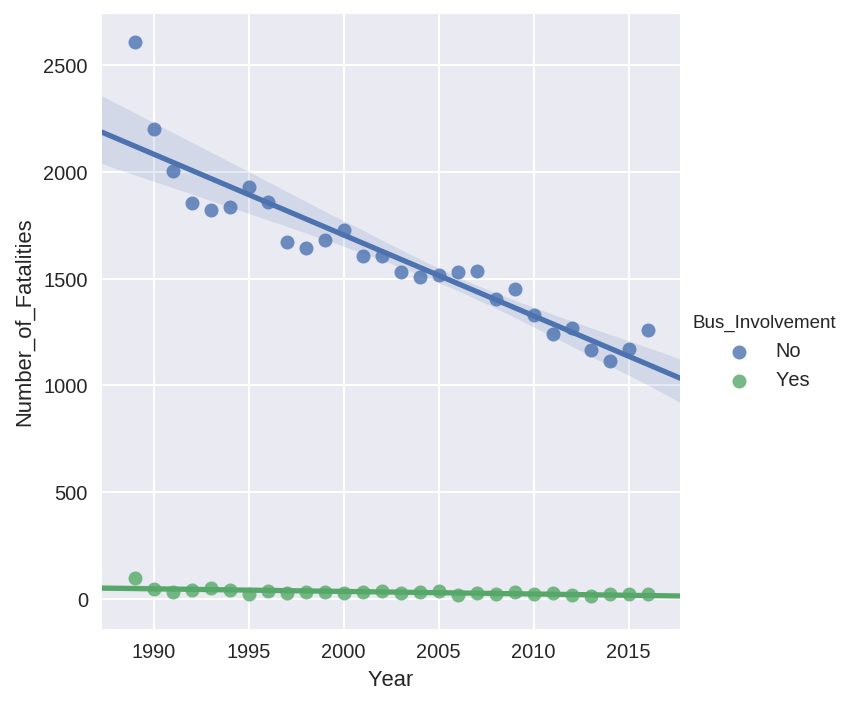

In [27]:
query ='''
select Year,Bus_Involvement, sum(Number_of_Fatalities) Number_of_Fatalities
 from fatal_clean
 where Year != 2017
 group by Bus_Involvement, Year
 order by 1 desc
'''
fatal_bus = get_data_from_db(query,db_file)
sns.lmplot(x='Year', y='Number_of_Fatalities', hue='Bus_Involvement',  data=fatal_bus)
plt.show()

### Number of Fatalities on each Gender per State
#### This shows that men has the highest number person died in road crashes per state.

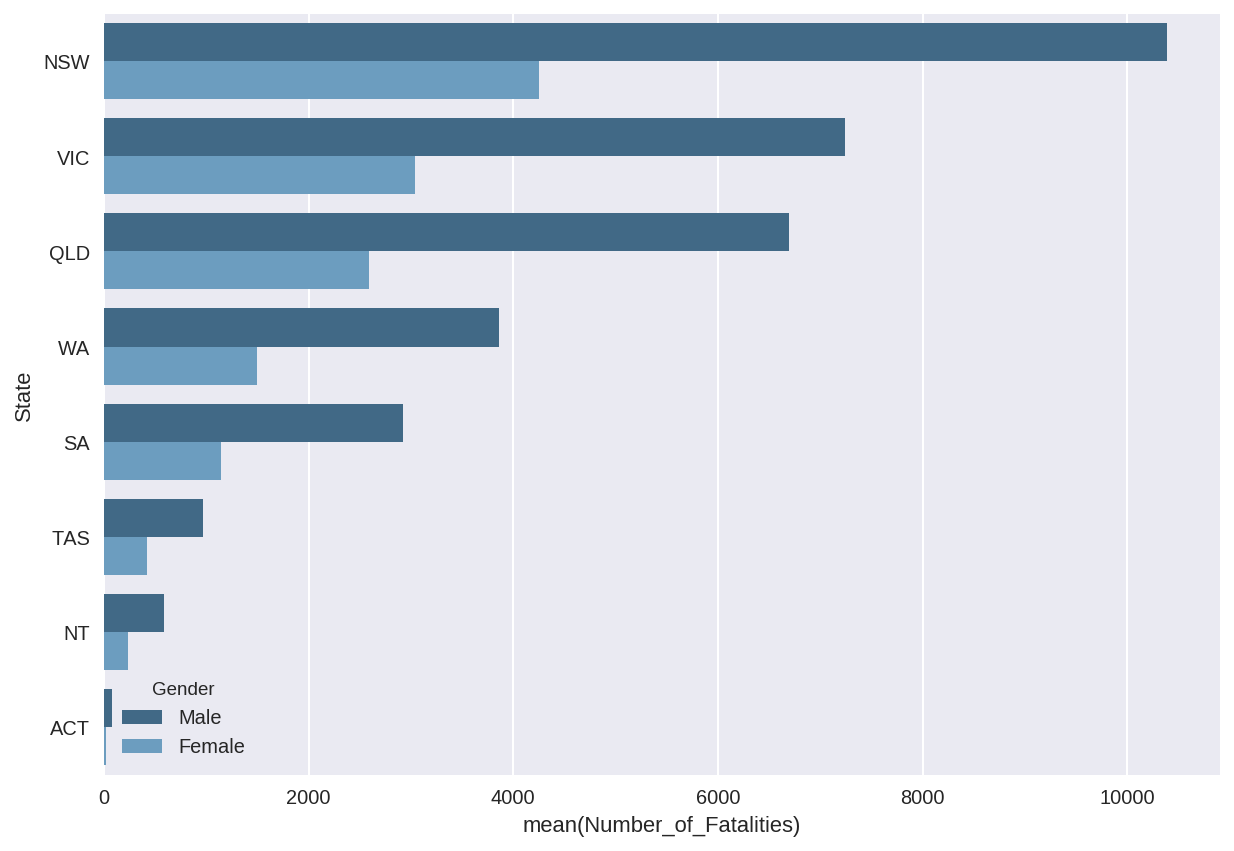

In [28]:
query ='''
SELECT State
     , Gender
     , sum(Number_of_Fatalities) as Number_of_Fatalities
  FROM fatal_clean
 GROUP BY State,Gender
 ORDER BY 3 DESC
'''
fatal_death_gender = get_data_from_db(query,db_file)
fatal_death_gender
ax = plt.subplots(figsize=(10, 7))
ax = sns.barplot(y="State", x="Number_of_Fatalities", hue="Gender", data=fatal_death_gender
                 ,orient='h',palette="Blues_d")

### Number of Fatalities per Age on each State
#### This shows that a lot of people died in road fatal crashes between age of 17 - 25 years of age from 1989 to 2016

This might be the reason why Australia implemented graduated licensing system for young drivers, lot young people at age between 17-25 years old die in road fatal accident. 

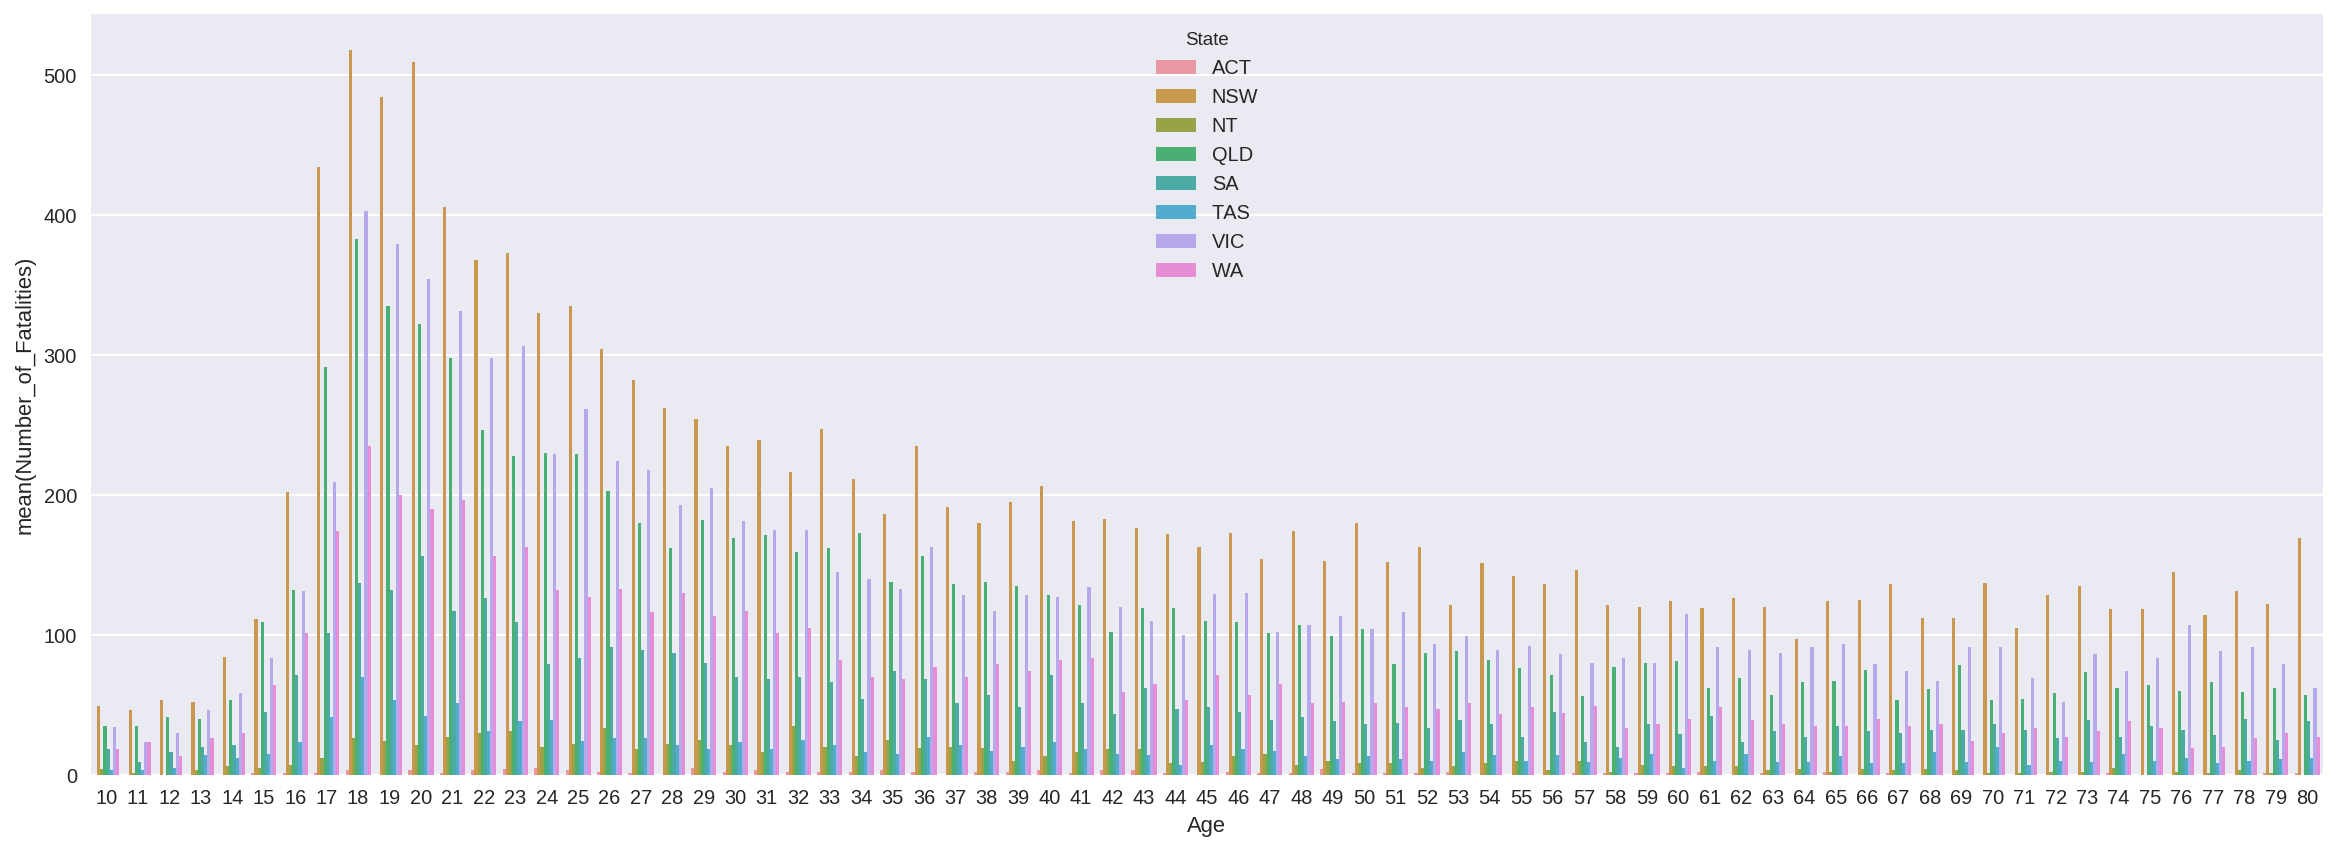

In [29]:
query ='''
SELECT Age,State, sum(Number_of_Fatalities) as Number_of_Fatalities
  FROM fatal_clean
 WHERE Age BETWEEN 10 AND 80
 GROUP BY State,Age
'''
fatal_death_age = get_data_from_db(query,db_file)

ax = plt.subplots(figsize=(20, 7))
ax = sns.barplot(x="Age", y="Number_of_Fatalities", hue="State", data=fatal_death_age,orient='v')

### Number of Fatalities for each hour per State
#### This shows that fatal road accident happen between 2:00pm and 6:00pm from 1989 - 2016

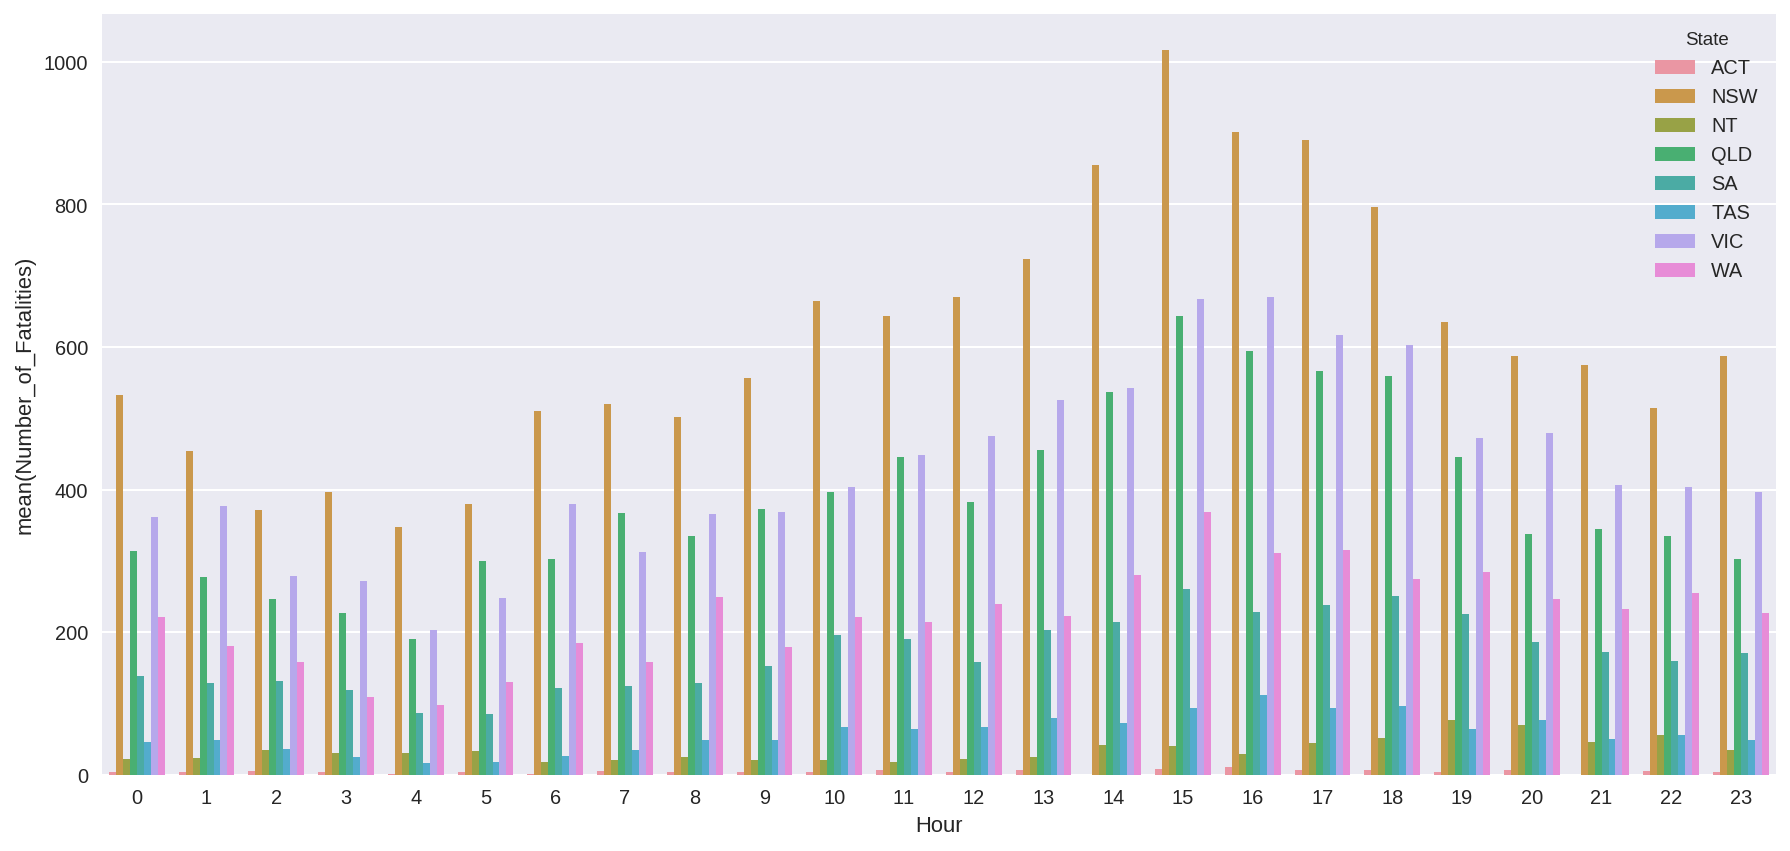

In [30]:
query ='''
SELECT Hour,State, sum(Number_of_Fatalities) as Number_of_Fatalities
  FROM fatal_clean
 GROUP BY State,Hour
'''
fatal_death_hour = get_data_from_db(query,db_file)

ax = plt.subplots(figsize=(15, 7))
ax = sns.barplot(x="Hour", y="Number_of_Fatalities", hue="State", data=fatal_death_hour,orient='v')

### Number of Fatalities for each month per State
#### This show that each state has evenly distributed number of road fatalities each month.

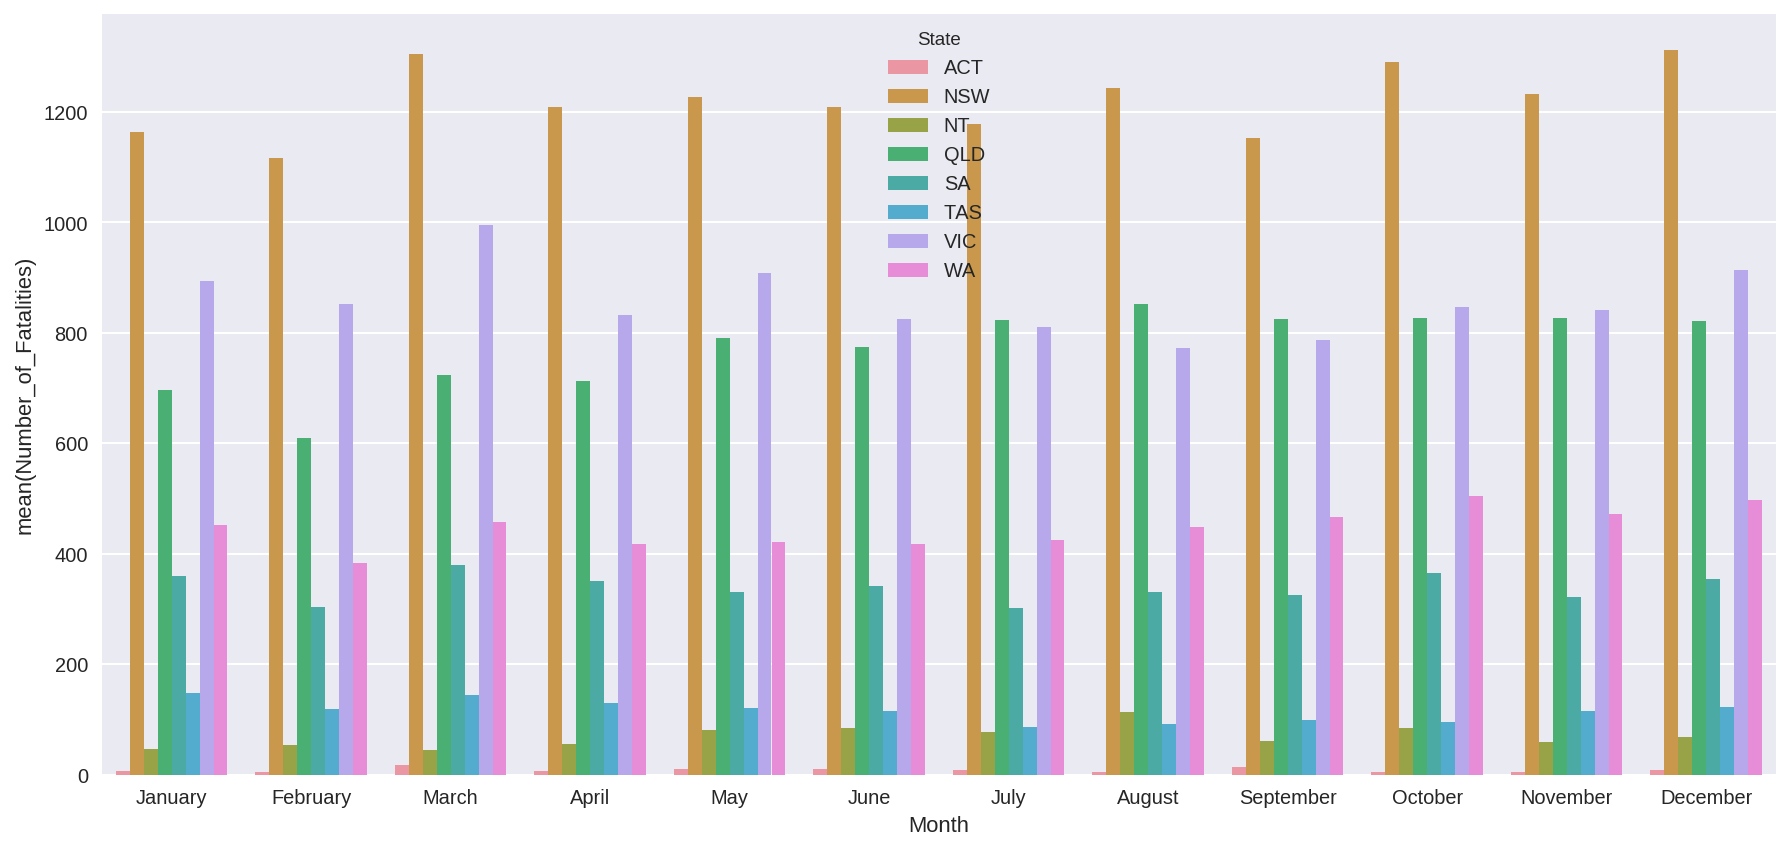

In [31]:
query ='''
SELECT Month,State, sum(Number_of_Fatalities) as Number_of_Fatalities
     , CASE WHEN Month = 'January' THEN 1
            WHEN Month = 'February' THEN 2
            WHEN Month = 'March' THEN 3
            WHEN Month = 'April' THEN 4
            WHEN Month = 'May' THEN 5
            WHEN Month = 'June' THEN 6
            WHEN Month = 'July' THEN 7
            WHEN Month = 'August' THEN 8
            WHEN Month = 'September' THEN 9
            WHEN Month = 'October' THEN 10
            WHEN Month = 'November' THEN 11
            WHEN Month = 'December' THEN 12
       END as Month_No
  FROM fatal_clean
 GROUP BY State,Month
 ORDER BY Month_No
'''
fatal_death_hour = get_data_from_db(query,db_file)

ax = plt.subplots(figsize=(15, 7))
ax = sns.barplot(x="Month", y="Number_of_Fatalities", hue="State", data=fatal_death_hour,orient='v')

---

### Models

### Discussion of model selection and implementation

#### Initially I didn't know that I could run a Linear Regression on my dataset. I was thinking for classification and clustering but while I'm playing the SQL and group some of the columns and tried to plot I found that there is Linearity in my cleaned dataset. I ask the instructor and she confirm that I can do Linear Regression.

#### I noticed also that my dataset has columns for Year, Month, Day, Hour and Minute which I can convert into Date column. In this case I can run Time Series 

#### I run both Linear regression and Time Series to predict if Australia can further reduce the number of road fatalities

---

Create copy of fatal dataframe and name it fatal_linear that will be use for linear regression to predict the number of fatalities in NSW per month

In [32]:
query ='''
select Year
     , SUM(Number_of_Fatalities) as Number_of_Fatalities
 from fatal_clean
 where Year != 2017
 group by Year
'''
fatal_mod1 = get_data_from_db(query,db_file)

#### Check the `fatal_mod1` datatypes

In [33]:
fatal_mod1.dtypes

Year                    int64
Number_of_Fatalities    int64
dtype: object

#### Check the `fatal_mod1` head

In [34]:
fatal_mod1.head()

Year  Number_of_Fatalities
0  1989                  2706
1  1990                  2245
2  1991                  2034
3  1992                  1891
4  1993                  1871

#### Check for the `fatal_mod1` shape

In [35]:
fatal_mod1.shape

(28, 2)

#### Describe `fatal_mod1`

In [36]:
fatal_mod1.describe()

Year  Number_of_Fatalities
count    28.000000             28.000000
mean   2002.500000           1640.285714
std       8.225975            348.166186
min    1989.000000           1135.000000
25%    1995.750000           1403.500000
50%    2002.500000           1598.000000
75%    2009.250000           1871.750000
max    2016.000000           2706.000000

#### Plot the data and this show the linearity
If you check the plot it shows that the number of fatalities goes down over the years. Will Australia will be able to continue to reduce it or it will goes up again?

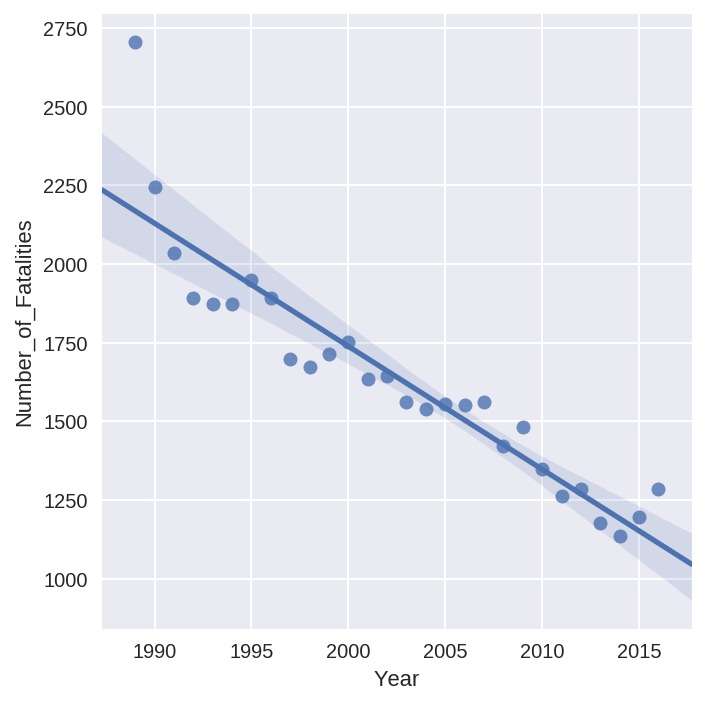

In [37]:
sns.lmplot(x='Year', y='Number_of_Fatalities',  data=fatal_mod1)
plt.show()

#### Copy the `fatal_mod1` dataframe into `fatal_linreg` dataframe

In [38]:
fatal_linreg = fatal_mod1.copy()

#### Check the number of rows and column of new dataframe.

In [39]:
fatal_linreg.shape

(28, 2)

#### Verfify the data types of `fatal_linreg` dataframe

In [40]:
fatal_linreg.dtypes

Year                    int64
Number_of_Fatalities    int64
dtype: object

In [41]:
fatal_linreg.head()

Year  Number_of_Fatalities
0  1989                  2706
1  1990                  2245
2  1991                  2034
3  1992                  1891
4  1993                  1871

### Description of defining variables
#### Let set the X predictors and y as our target.

Our target or y will be the `Number_of_Fatalities` because I want to predict if Australia will continue and X predictors is column Year which only left when I group my data by Year. In this case I could run only simple linear regression and no longer to do feature selection because of only one predictors left in this case.

In [42]:
x_predictors=[col for col in fatal_linreg.columns if col not in ['Number_of_Fatalities']]
X=fatal_linreg[x_predictors]
y=fatal_linreg.Number_of_Fatalities.values 
ss = StandardScaler()
Xs = ss.fit_transform(X)

#### Train model and Test it

In [43]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.4)

In [76]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))

0.750145483797


In [77]:
#slope
print(lr.coef_)

[-362.29549207]


In [78]:
#intercept
print(lr.intercept_)

1692.1050389


### Tune Linear Model
---
I did not get much time too look for Robust Regression is good for data with a lot of noise. I can explore more in TheilSen, RANSAC and Huber regression.

#### Perform 10 fold cross validation and it return very poor mean cross validation score.

In [79]:
scores = cross_val_score(lr, X_test, y_test, cv=10)
print ("Cross-validated scores:", scores)
print ("Mean Cross validation",scores.mean())

Cross-validated scores: [ 0.91835457  0.67665483  0.          0.          0.          0.          0.
  0.          0.          0.        ]
Mean Cross validation 0.159500940068


#### The Linear regression model doesn't gave better result after I did a cross validation. One reason I see is the noise presence in my data. This gave me a go signal to do the Time Series.
---

### Time Series Forecasting and Assesing Trend

I would like to do time series on my dataset as I have date and time column as my predictors. I'm wondering this will give me better preditions result compare to Linear I did.

Fetch the data from database and load in dataframe. I group the data by Date and get the SUM of Number_of_Fatalities for whole Australia.

In [49]:
db_file = './db/australia_roads.db.sqlite'
query ='''
select Year 
       || '-' 
       || CASE WHEN Month = 'January' THEN 1
               WHEN Month = 'February' THEN 2
               WHEN Month = 'March' THEN 3
               WHEN Month = 'April' THEN 4
               WHEN Month = 'May' THEN 5
               WHEN Month = 'June' THEN 6
               WHEN Month = 'July' THEN 7
               WHEN Month = 'August' THEN 8
               WHEN Month = 'September' THEN 9
               WHEN Month = 'October' THEN 10
               WHEN Month = 'November' THEN 11
               WHEN Month = 'December' THEN 12
           END
        || '-'
        || Day as Date
     , SUM(Number_of_Fatalities)Number_of_Fatalities
  from fatal_clean
 group by Date
 order by 1
'''
fatal_time= get_data_from_db(query,db_file)

#### Check the data I have fetch

At this point the data are group by Date column.This column should be converted as our index so that we can start the time series modelling. But first we need to check our data.
We can start to look the columns and the first 50 rows.

In [50]:
fatal_time.head(50)

Date  Number_of_Fatalities
0     1989-1-1                     8
1    1989-1-10                     7
2    1989-1-11                     8
3    1989-1-12                     7
4    1989-1-13                    13
5    1989-1-14                     4
6    1989-1-15                     8
7    1989-1-16                     3
8    1989-1-17                     2
9    1989-1-18                     8
10   1989-1-19                     3
11    1989-1-2                     9
12   1989-1-20                     5
13   1989-1-21                    15
14   1989-1-22                    10
15   1989-1-23                     2
16   1989-1-24                     5
17   1989-1-25                     6
18   1989-1-26                     7
19   1989-1-27                    16
20   1989-1-28                    12
21   1989-1-29                     9
22    1989-1-3                     2
23   1989-1-30                     5
24   1989-1-31                     6
25    1989-1-4                     5
26    1989-1-5                     7
27    1989-1-6                     8
28    1989-1-7                     7
29    1989-1-8                     6
30    1989-1-9                     8
31   1989-10-1                     9
32  1989-10-10                     4
33  1989-10-11                    15
34  1989-10-12                     5
35  1989-10-13                     9
36  1989-10-14                    11
37  1989-10-15                     8
38  1989-10-16                     8
39  1989-10-17                     7
40  1989-10-18                     2
41  1989-10-19                    11
42   1989-10-2                     8
43  1989-10-20                    25
44  1989-10-21                    11
45  1989-10-22                    11
46  1989-10-23                     5
47  1989-10-24                     3
48  1989-10-25                    16
49  1989-10-26                     7

#### We could check also the data types of our dataset
We see that Date is a object, but we need to know what type of object it is.

In [51]:
fatal_time.dtypes

Date                    object
Number_of_Fatalities     int64
dtype: object

#### I found out that Date column is a string object type. We need to set it as our Index and set it a Datetime object

In [52]:
fatal_time['Date']
type(fatal_time['Date'].loc[0])

str

#### Let set first it as our Index

In [53]:
fatal_time.set_index('Date', inplace=True)

#### We have set Date as our index, we can now convert our index Date as a Datetime object

In [54]:
fatal_time.index = pd.to_datetime(fatal_time.index)

#### Let us now check if we have set the Date as our index and with correct object type

In [55]:
fatal_time.head()

Number_of_Fatalities
Date                            
1989-01-01                     8
1989-01-10                     7
1989-01-11                     8
1989-01-12                     7
1989-01-13                    13

In [56]:
fatal_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9925 entries, 1989-01-01 to 2016-09-09
Data columns (total 1 columns):
Number_of_Fatalities    9925 non-null int64
dtypes: int64(1)
memory usage: 155.1 KB


#### Working on daily data is bit complex because of short amount of time, lets convert out data into monthly average of Number_of_Fatalities by using resampling.

In [57]:
y = fatal_time['Number_of_Fatalities'].resample('MS').mean()

#### Let's now check our data, see if we have converted into monthly average
If you will notice the resample function group it by month by taking first day on each month and calculate the average per month.

In [58]:
y.head(20)

Date
1989-01-01    7.129032
1989-02-01    7.321429
1989-03-01    8.233333
1989-04-01    5.733333
1989-05-01    6.806452
1989-06-01    8.366667
1989-07-01    6.612903
1989-08-01    6.677419
1989-09-01    8.700000
1989-10-01    7.419355
1989-11-01    6.633333
1989-12-01    9.580645
1990-01-01    5.533333
1990-02-01    5.857143
1990-03-01    7.000000
1990-04-01    5.600000
1990-05-01    5.870968
1990-06-01    7.200000
1990-07-01    6.225806
1990-08-01    5.709677
Freq: MS, Name: Number_of_Fatalities, dtype: float64

#### Let see if we have any missing values for time series

We don't have missing values for our data, we no longer need to use the fillna() function.

In [59]:
y.isnull().sum()

0

#### Let's plot our data and see how it goes.
Looking at it and shows that there are lot of noise on hte data

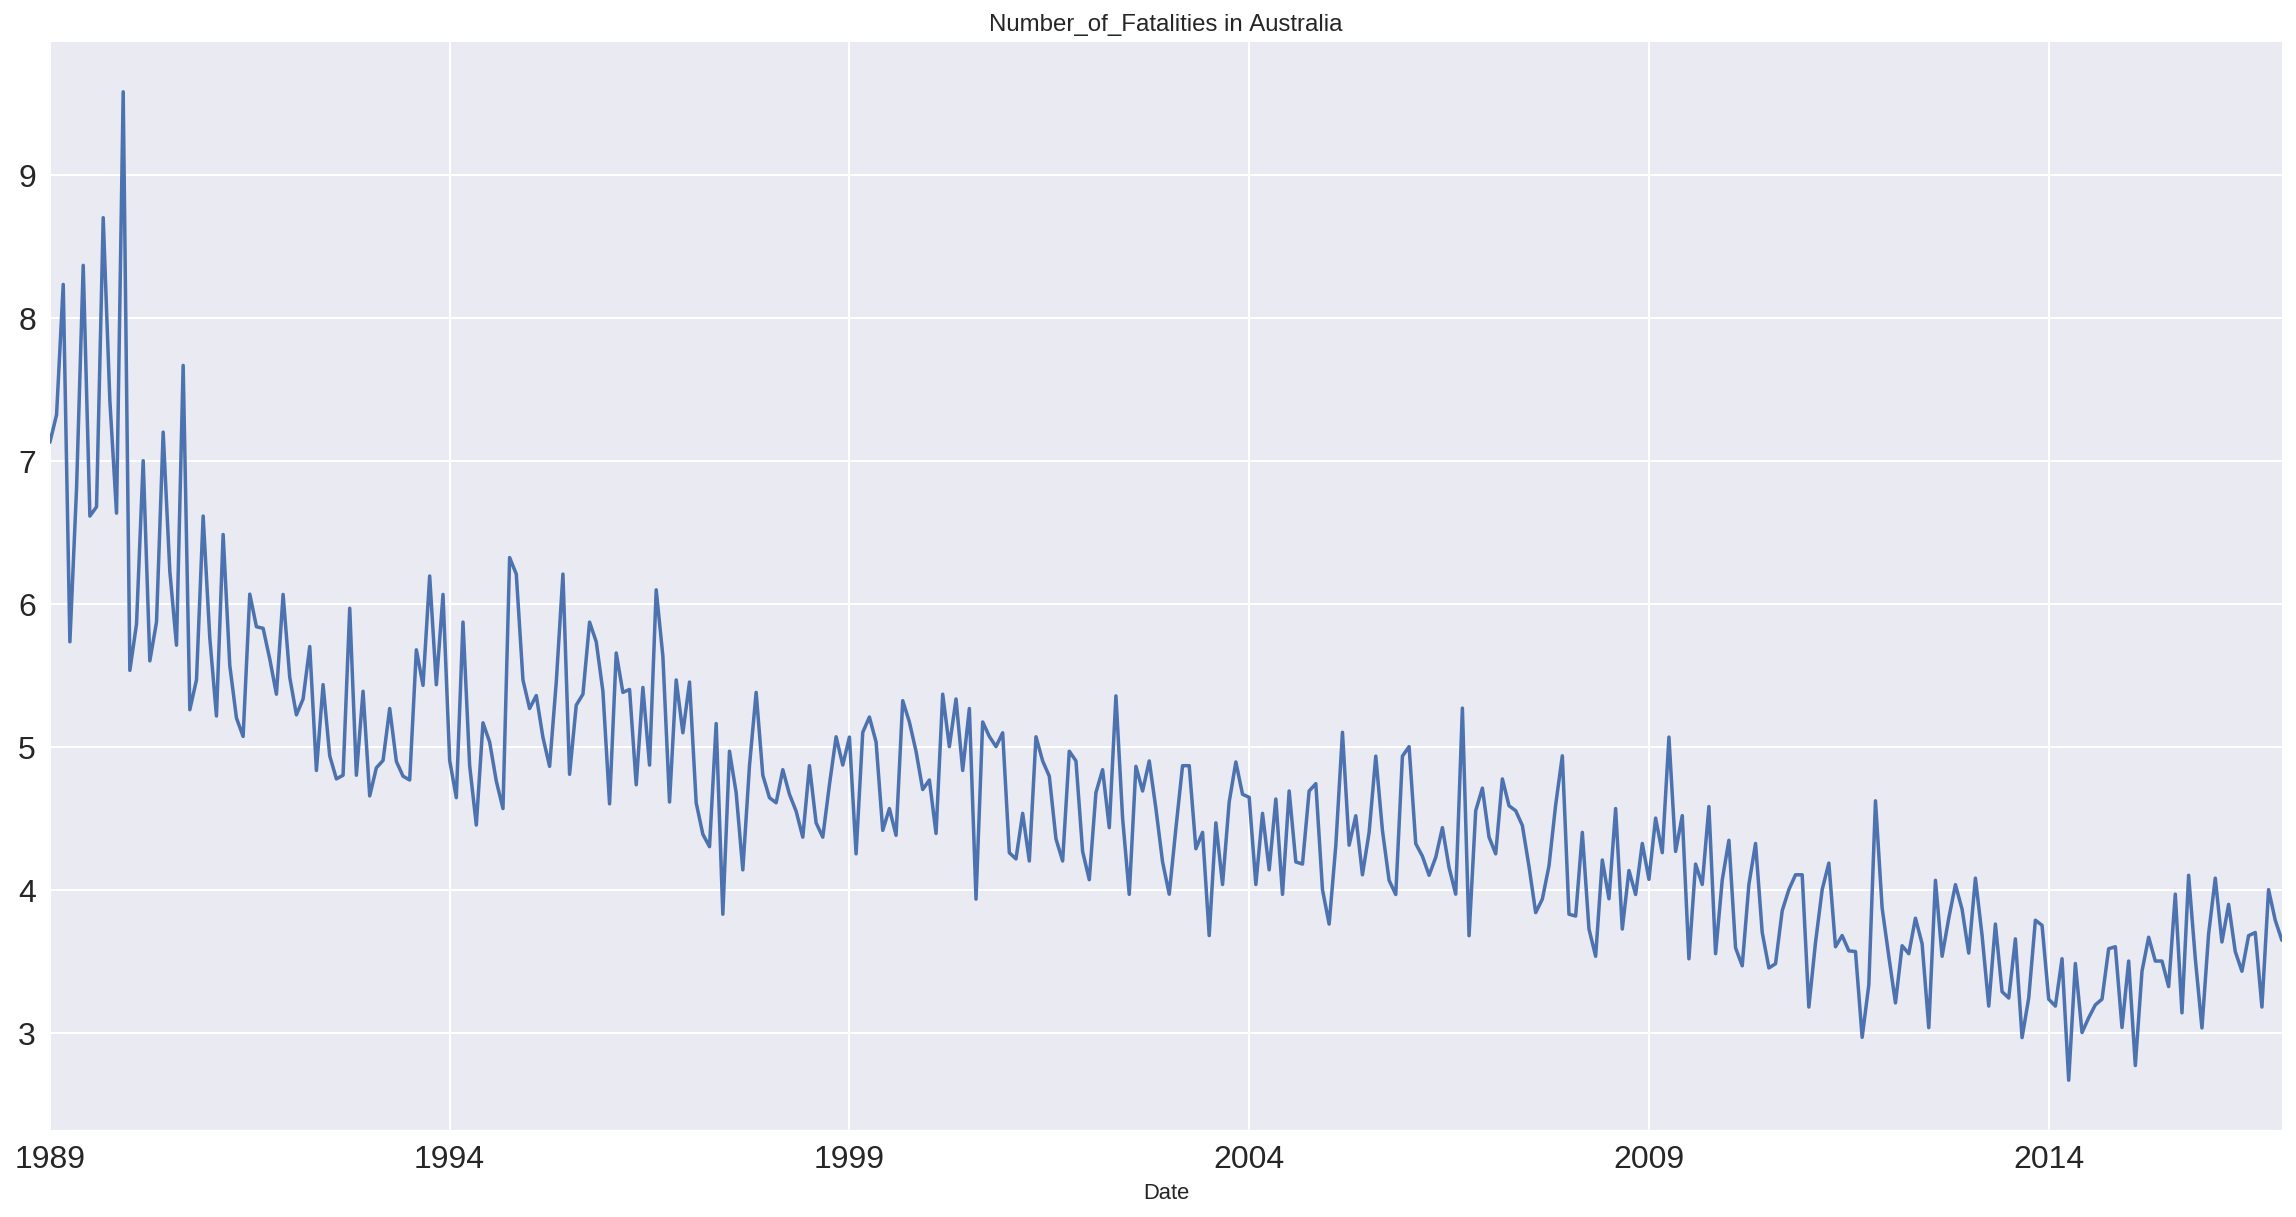

In [60]:
y.plot(figsize=(20,10), title= 'Number_of_Fatalities in Australia', fontsize=16)

#### We can also visualize our data using a method called time-series decomposition. Time series decomposition allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

If you will notice we have **_downtrend_** for Number of Fatalities in this case.

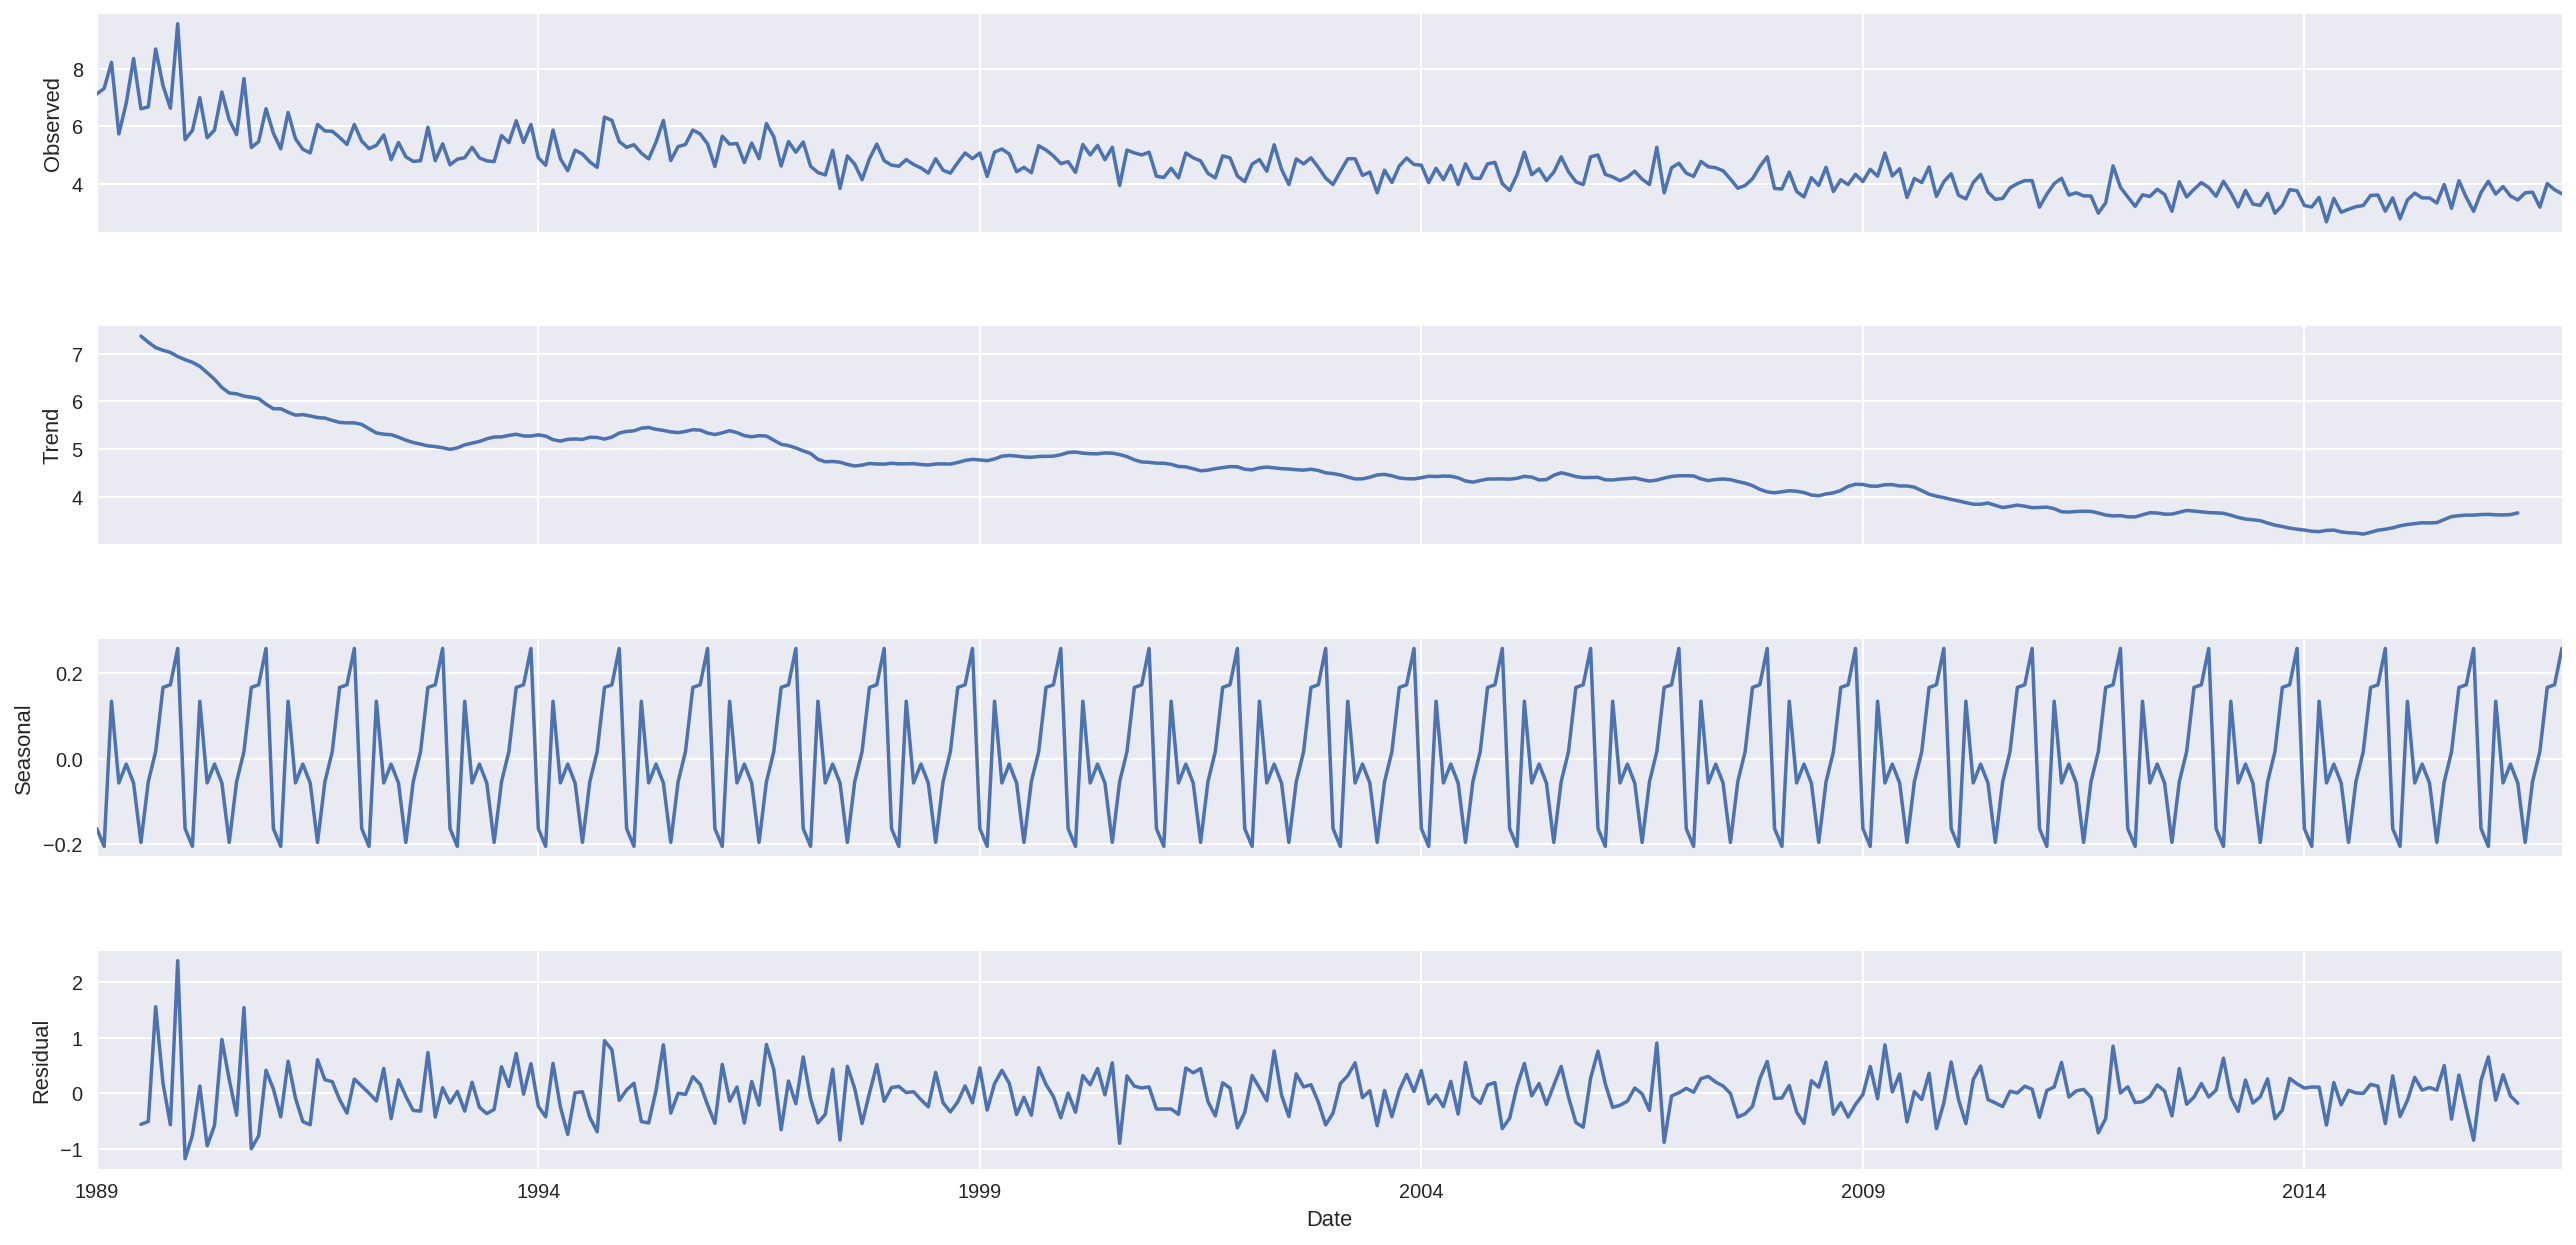

In [61]:
decomposition = seasonal_decompose(y, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)
plt.show()

#### Now that we've converted and explored our data, let's move on to time series forecasting with ARIMA.

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for AutoregRessive Integrated Moving Average. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.

There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets

Programmatically select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality.

In [62]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations. This process is known as grid search (or hyperparameter optimization) for model selection.

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels

In [63]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1536.6614350479904
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:518.2091469430007
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:577.7707825922455
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:537.3349671489477
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:520.440859678647
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:467.57511904111186
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1612.8663608709949
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1267.3733331179708
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:588.6794875449248
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:503.8441837703547
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:569.7880881568766
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:519.7385988336904
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:512.3649827748483
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:458.59412440157394
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:574.444024146542
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:635.7306074551216
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:554.7059950187909
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:546.5446289716882
ARIMA(0

#### The output of code suggests that SARIMAX(0, 1, 1)x(1, 0, 1, 12)yields the lowest AIC value of 360.6906. We should therefore consider this to be optimal option out of all the models we have considered. But when I tried it the it does not gave me better result instead the one below is much more better [SARIMAX(0, 0, 1)x(1, 0, 1, 12)].

The result shows that there is a bit big value for standard error but overall it seems good.

In [64]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 0, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1770   5.03e-05   3522.275      0.000       0.177       0.177
ar.S.L12       0.9713   1.71e+04   5.67e-05      1.000   -3.36e+04    3.36e+04
ma.S.L12      -0.5919    1.5e-05  -3.94e+04      0.000      -0.592      -0.592
sigma2         0.2823   3.15e-05   8956.736      0.000       0.282       0.282


Our concern here is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

Checking the residual we can see that it not perfectly normally distributed but we can say that is good enough but i think we can still improve it. The histogram on uppper right side shows that KDE(line in color green) is trying to follow the N(0,1) standard notation for a normal distribution with mean 0. 

I could say this is not perfectly distributed but good enough to consider.

<function matplotlib.pyplot.show>

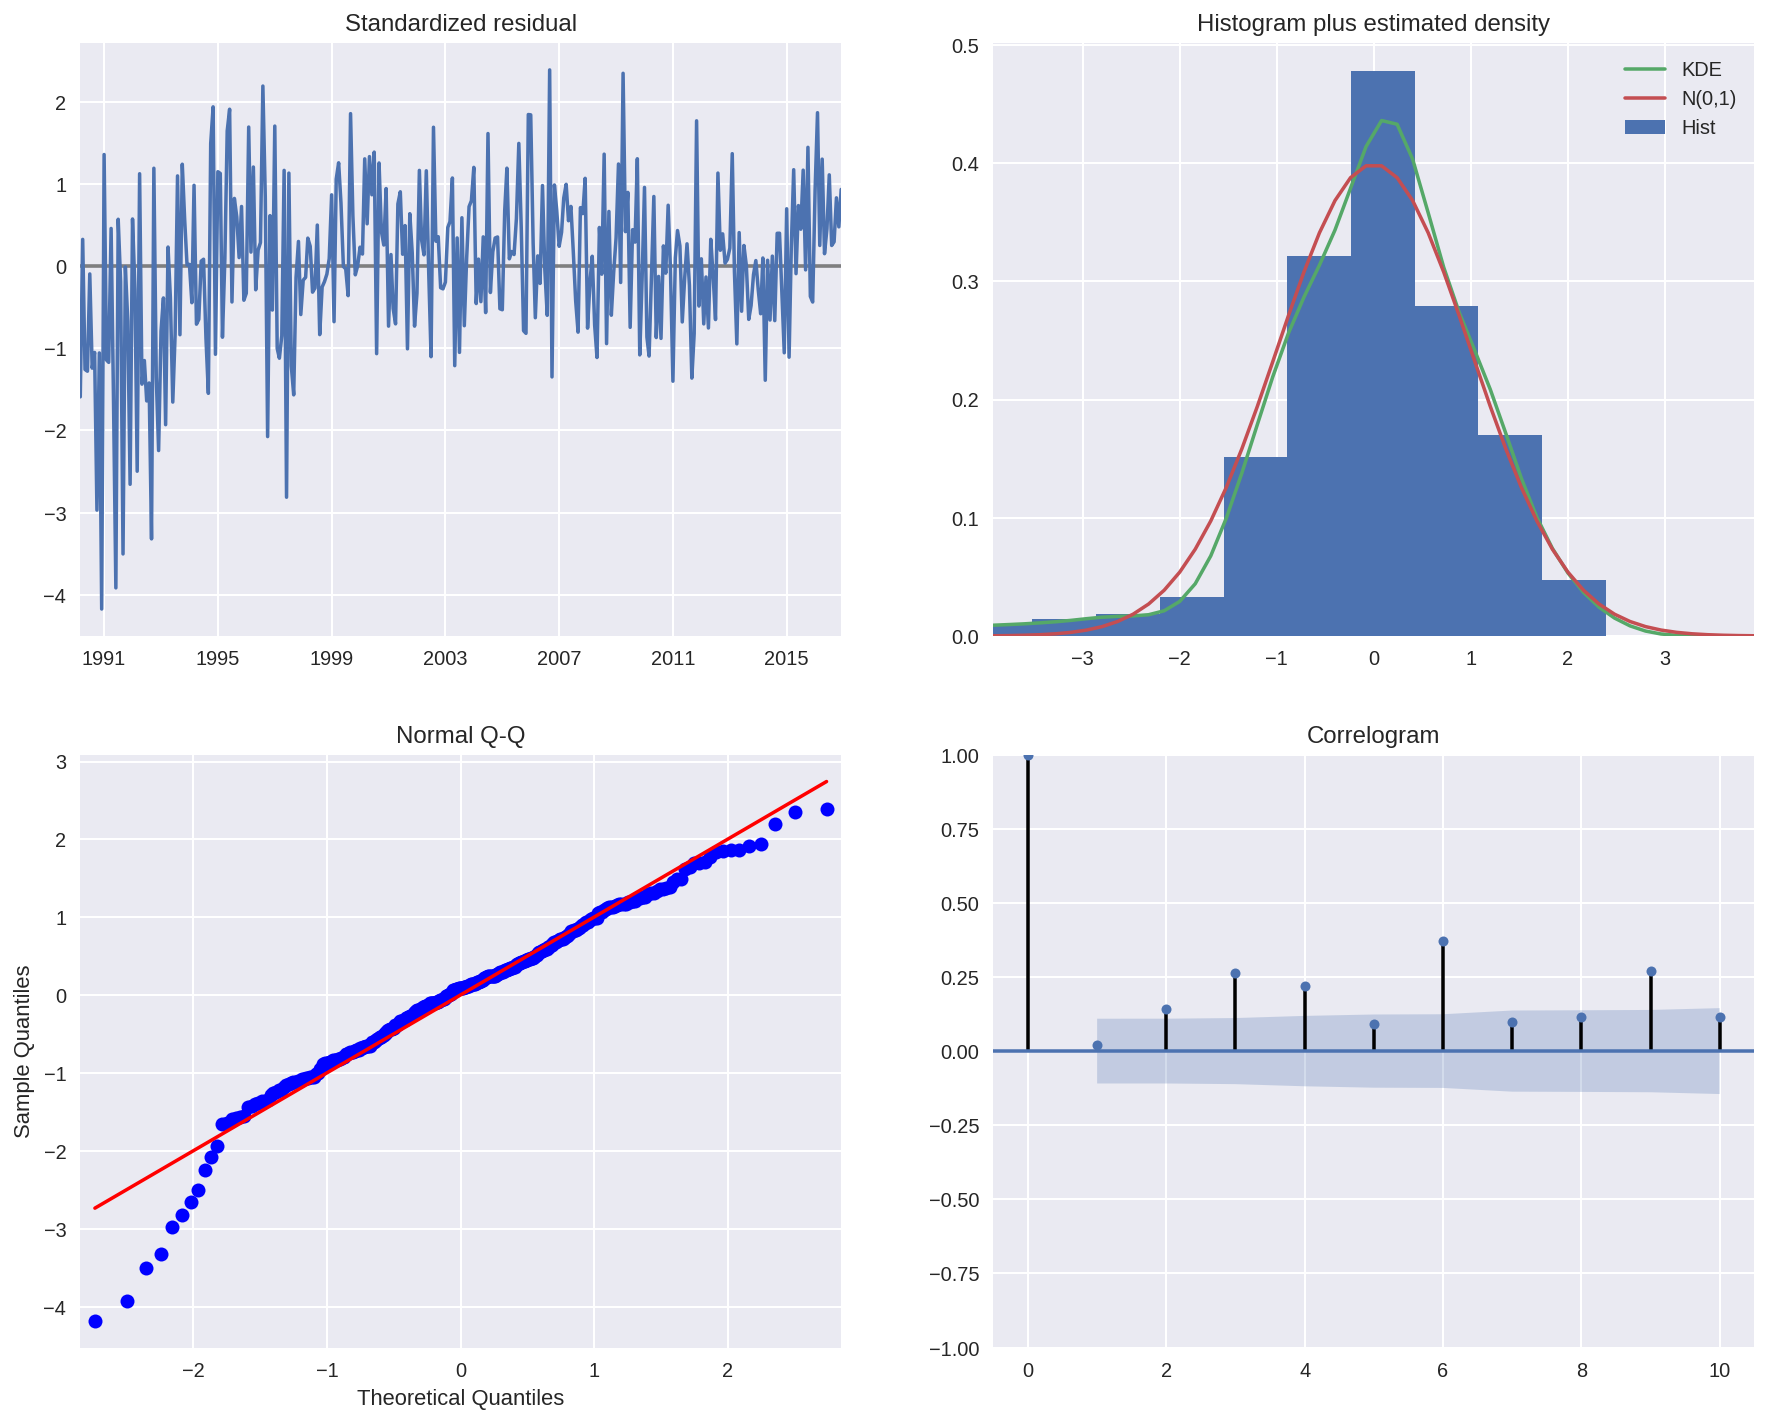

In [65]:
results.plot_diagnostics(figsize=(15, 12))
plt.show

#### We got our model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts.

The `dynamic=False` argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

In [66]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int()

###  Plot the real and forecasted values

Our forecasts does not align perfectly with the true values very well, but if we could notice that it follow the pattern and only bit lower to original data.

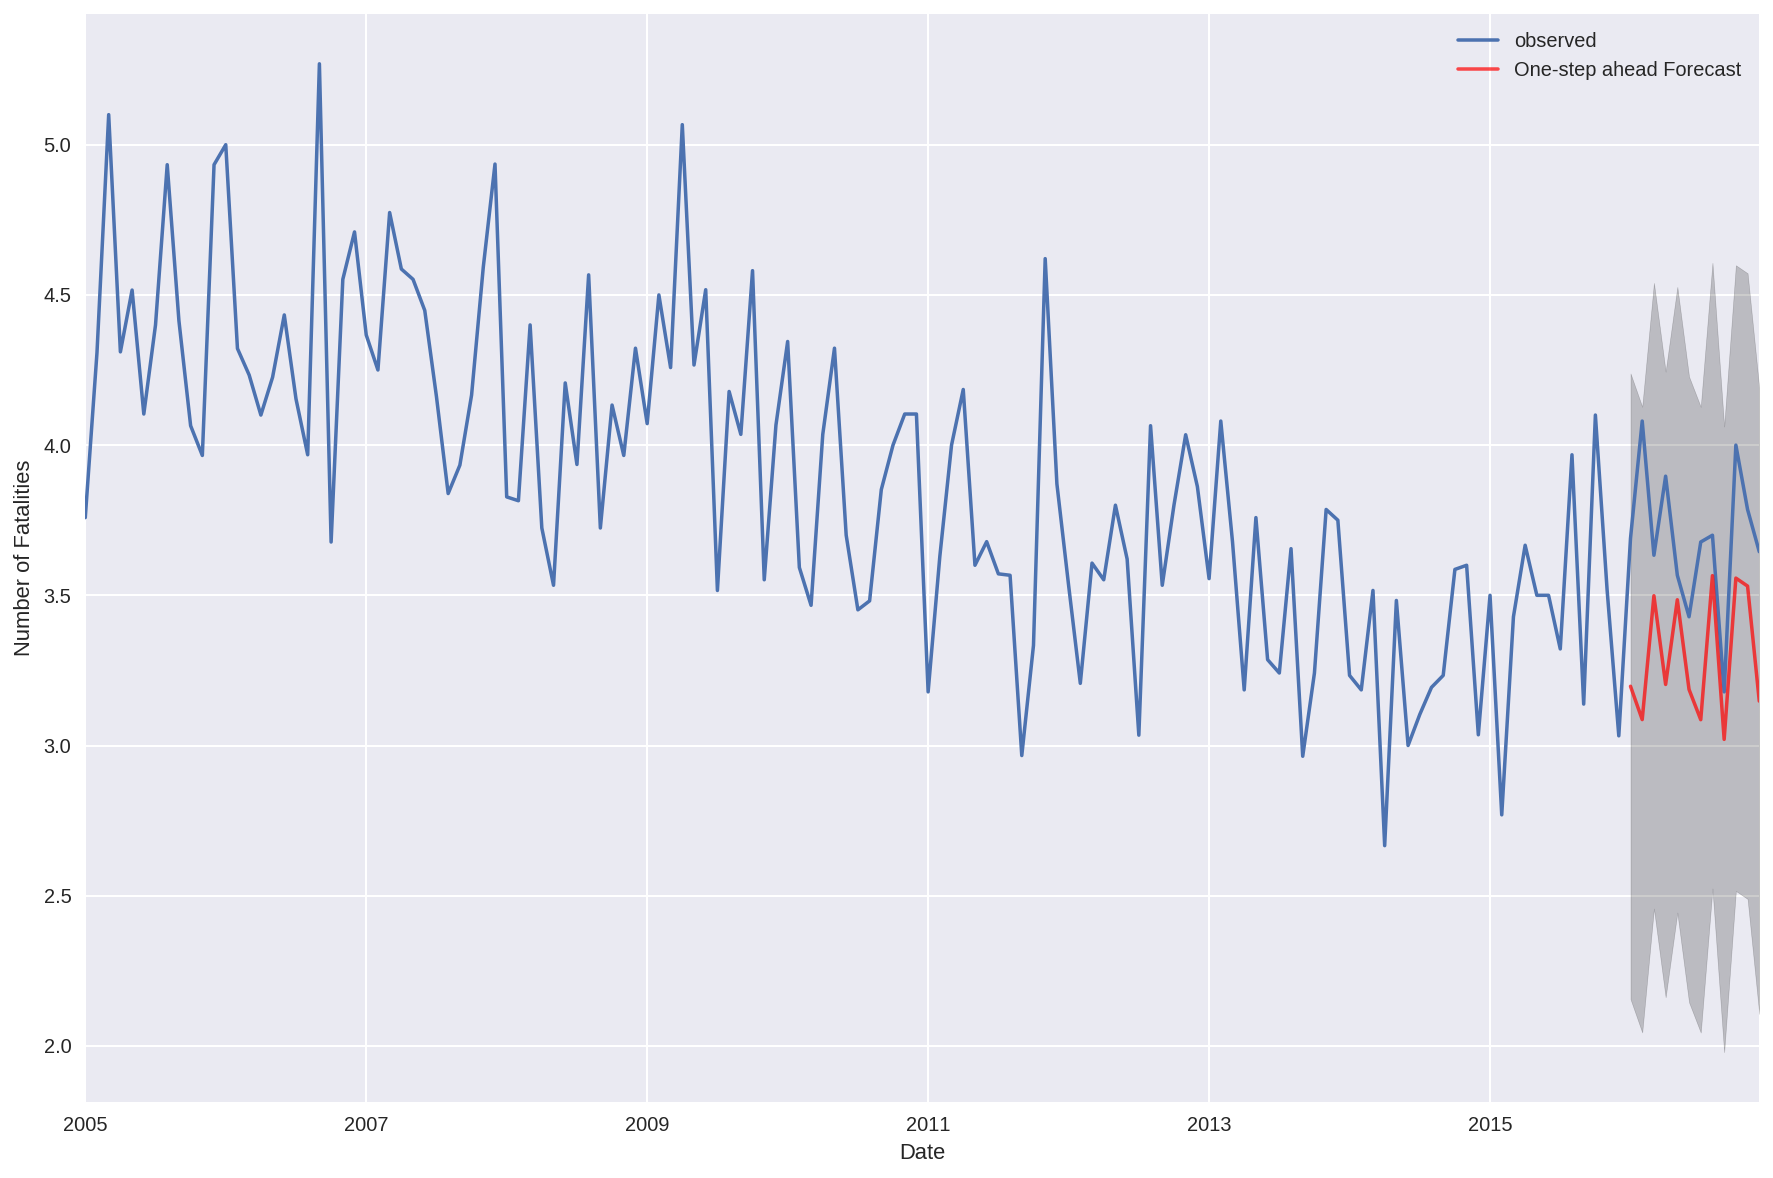

In [67]:
plt.figure(figsize=(15,10))
ax = y['2005':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, color='r')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Fatalities')
plt.legend()

plt.show()

#### We quantify the predictive performance of our forecasts by computing the MSE

In [68]:
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.22


### Producing and Visualizing Forecasts

Our forecasts show that the number of fatalities continue in decreasing trend for sometime but as we forecast further out into the future, it is natural for us to become less confident in our values. Australia will continue to reduce its number of fatalities. 

In [69]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

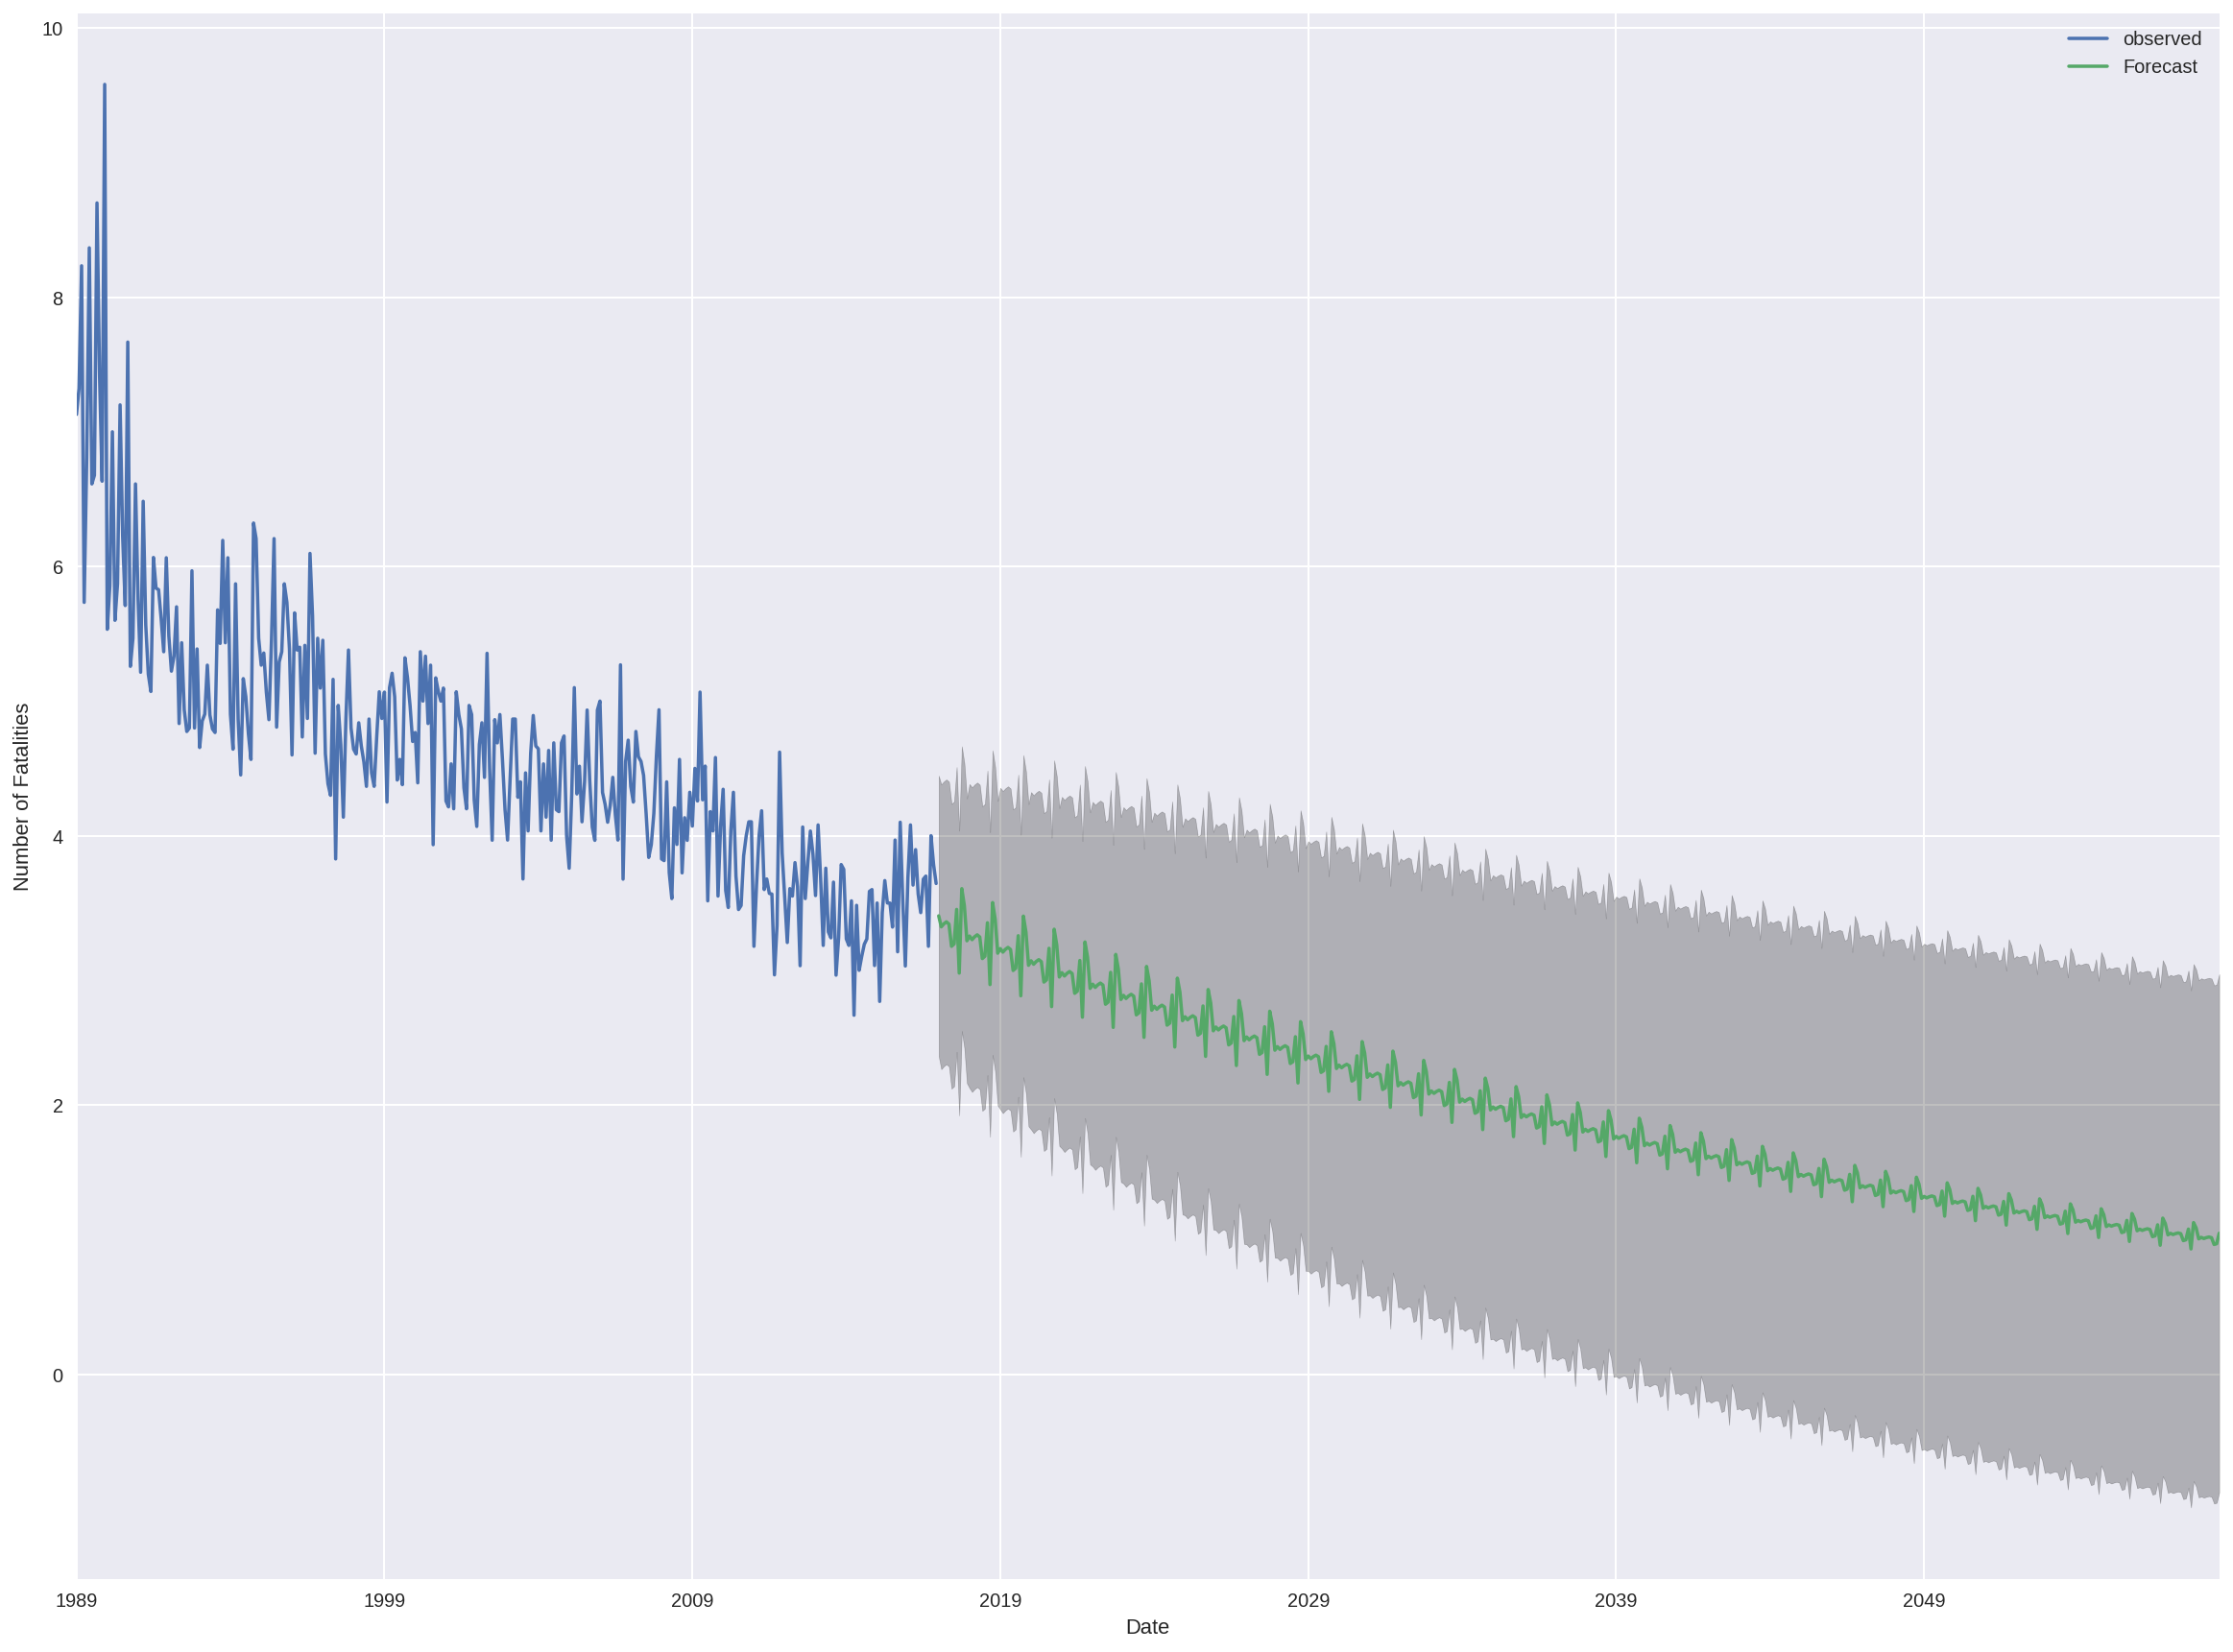

In [70]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Fatalities')

plt.legend()
plt.show()

## Interpretation of findings & relation to goals/success metrics
---

Australia can further reduce the number of road fatalities give the government and people working with them to come up for more initiatives and policies to control the accident and reduce the fatalities. 

Values information we got like population is correllated with number of road fatalities. Australia has growing number of population, one of the contributor is the number of increasing migrants at some point that need to used the road they must have pass the driving test with high accuracy to overcome the road hazards in road. 


## Executive Summary
---

#### Adrian Censon
 GA Data Scientist


### Purpose

The purpose of this study is to address the question **_"Can Australia continue to reduce further the number of road fatalities?"_**. 

Fatal Road Crashes is a problem for both developing and developed countries like Australia. The World Health Organization consideres this as a health community issue and recommends making it a political priority. A lot of initiatives and policies are implemented by Australia and they give impact to reduce the number of fatalities. 

The focus of this study is twofold, firstly to address the loss of life in traffic accidents. In a single blink of eye life can change for an individual, a family and even whole communities with the loss of individual lives. In addition to this very serious issue of the loss of life accidents can also affect the functionality of whole cities. Road accidents at some point can cause traffic congestion, problems with supply delivery and the operation of any city or area.

Predicting if Australia can further reduce the number of road fatalities will give both Government and people/industries working with them an interest to work more and come up for mmore initiative and policies to make  road safer for all.

### Methods

In this study I used Data Science which have some tools and statistical process to analyze and predict if Australia can further the number of road fatalities. The results are all based on evidence from data we have.

### Results

I did some analysis and here what i found:

 1. NSW has the most number of road fatalities compare with other State. Found that population is correllated to 
    to number of road crash fatalities. 
 2. More men die in road fatal crashes in all State of Australia. 
 3. A lot of people died in road fatal crashes between age of 17 - 25 years of age from 1989 to 2016
 4. Fatal road accident happen between 2:00pm and 6:00pm from 1989 to 2016.
 5. Less accident where bus is involve and also less people died if bus is involve. For this case I would say that
    even before bus, train and tram are safer means of transportation for us.

The result of my prediction is, **_Australia can further reduce the number of road fatalities_**. But since the prediction is only accurate on certain time frame, as we predict further in future our prediction get less confident.

### Conclusion

Government and industries did a good job to address the issue on road accidents. They implemented effective policies to reduce number of accidents and also number of road fatalities in Australia. We should also need to take note that population is correllated to number of road crash fatalities.

### Recommendation

Even our prediction says that Australia can further reduce the number of road fatalities, Government and people working with them  should continue to work in creating policies and initiatives to reduce the number of road fatalities because prediction applicable only for certain time frame and at the same time there might new factors might come up that will cause great impact. 

Since bus, train or tram are considered a safer means of transportation, Government can have wide information campaign to tell people that there are safe and affordable means of transportation option whenever its applicable on them. 

Adding more jobs in more location or near people home will make give great impact for count of accident and definitely help to reduce further more the number of road fatalities.

I can look further also if rainfall/weather, road condition, stress level of driver will give predictive power on predicting the number of fatalities.

